In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from aux import *
from visualize import *
from model import *

In [2]:
DATA_PATH = '../Data/'
class_ids = sorted([int(file_name.split('_')[0]) for file_name in os.listdir(DATA_PATH) if file_name.endswith('sex.csv')])

# networks and affective matrices of all classes in wave 1
networks = {}
affective_matrices = {}
for class_id in class_ids:
    networks[class_id] = load_data(class_id, 1)
    affective_matrices[class_id] = pd.read_csv(DATA_PATH + str(class_id) + '_affective_w1.csv', \
                                               header = 0, index_col = 0)
    

In [3]:
# Game Structure
PAYOFF_FUNCTION = {('tell a secret', 'tell a secret'): (1, 1),
                   ('tell a secret', 'refrain'): (-1, 0),
                   ('refrain', 'tell a secret'): (0, -1),
                   ('refrain', 'refrain'): (0, 0)}

In [4]:
### Simulation by using logistic regression

In [5]:
# Set parameters
NUM_STEP = 6
bonus_for_friends = 0.6395
mode = 'logistic regression'

In [6]:
# Prepare for simulation
simulated_networks = {}

for class_id in class_ids:
    trust_network = networks[class_id]
    affective_matrix = affective_matrices[class_id]
    model = TrustModel(trust_network, affective_matrix, mode, bonus_m2m = 0, bonus_f2f = 0, bonus_for_friends = 0)
    simulated_networks[class_id] = model.run(NUM_STEP)

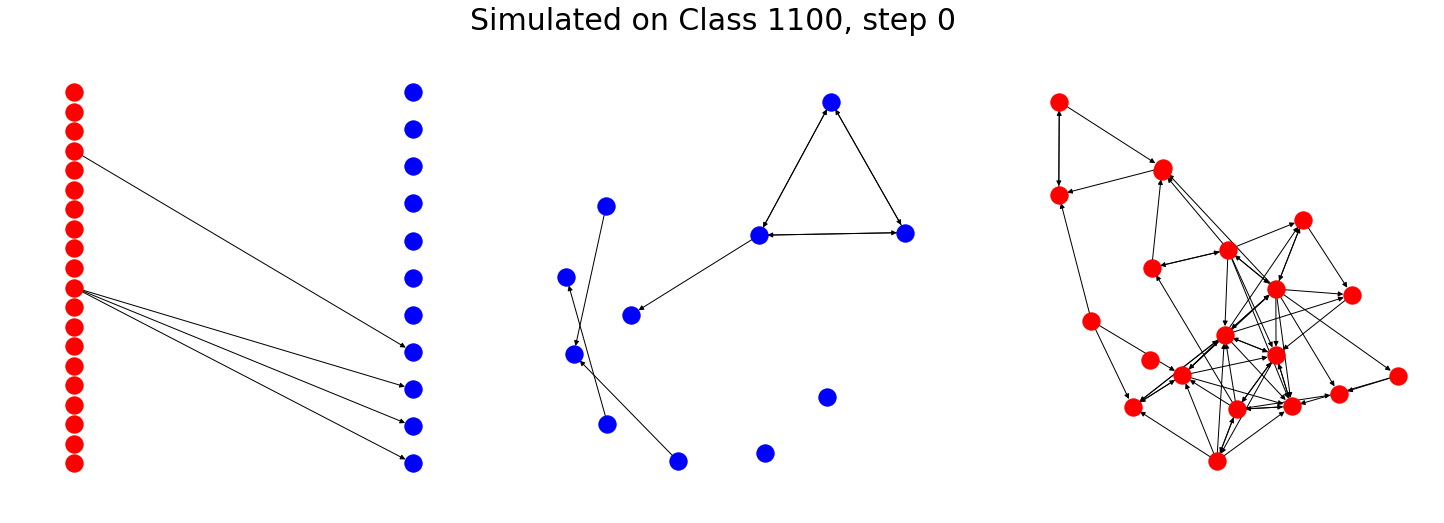

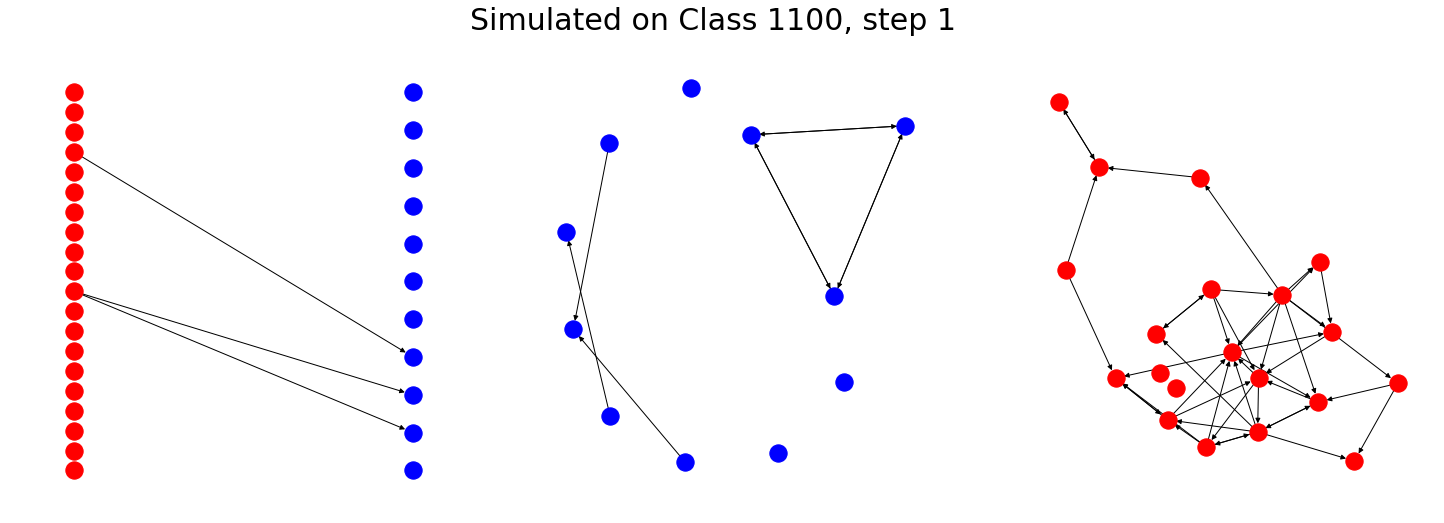

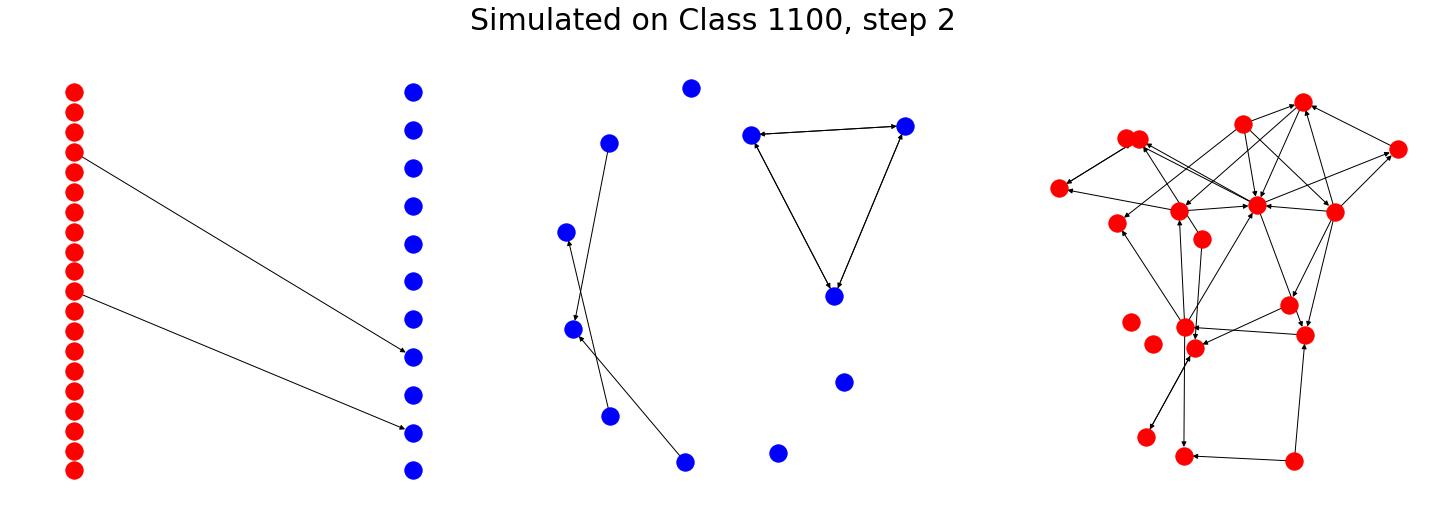

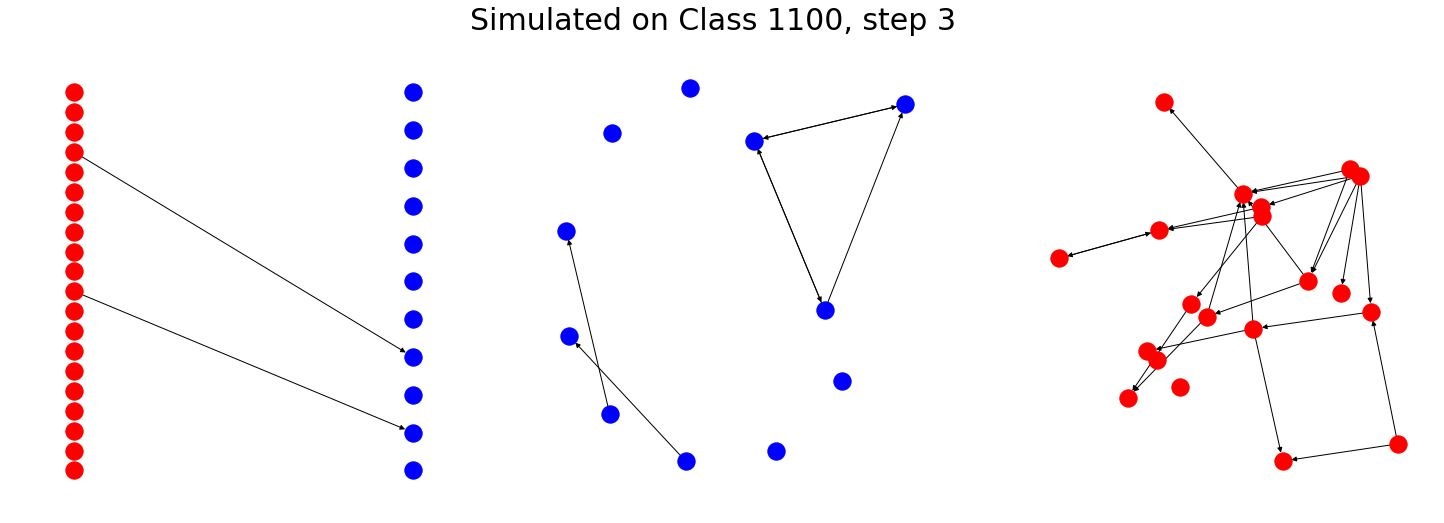

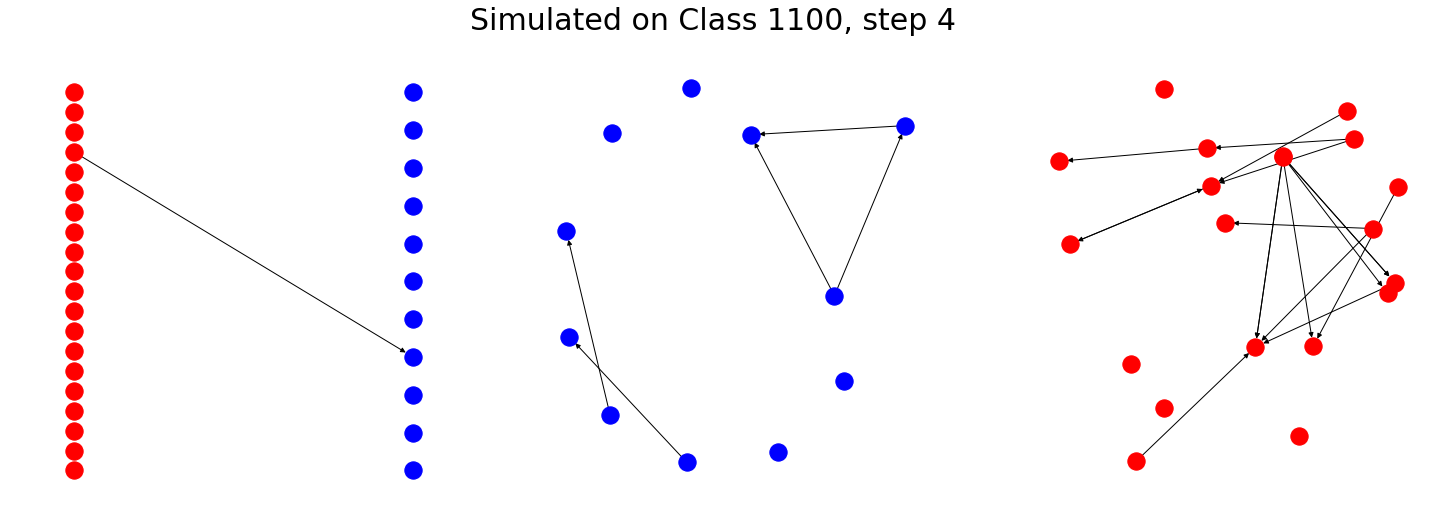

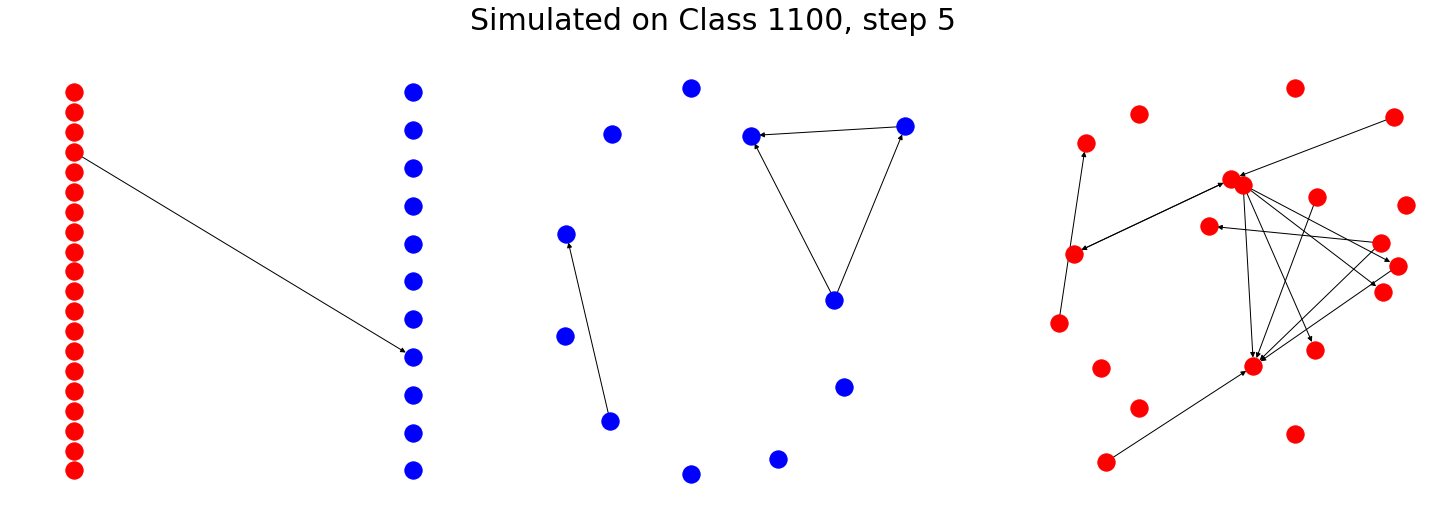

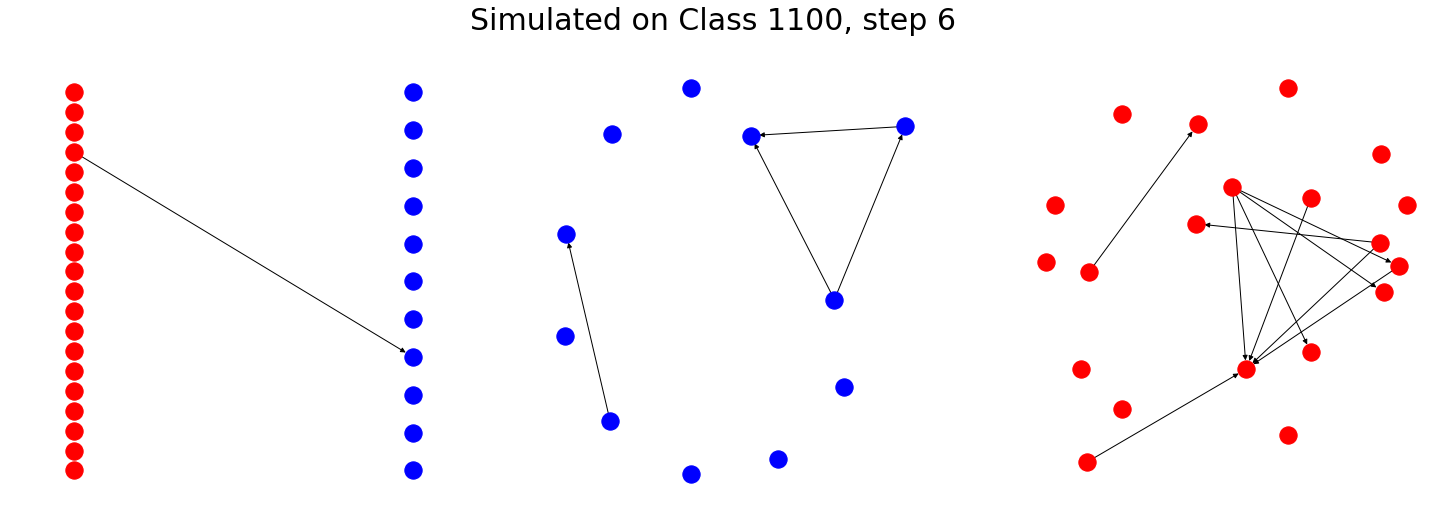

In [7]:
# Visualize a class in all steps
SELECTED_CLASS = 1100
for step in range(NUM_STEP + 1):
    visualize(simulated_networks[1100][step], SELECTED_CLASS, step)

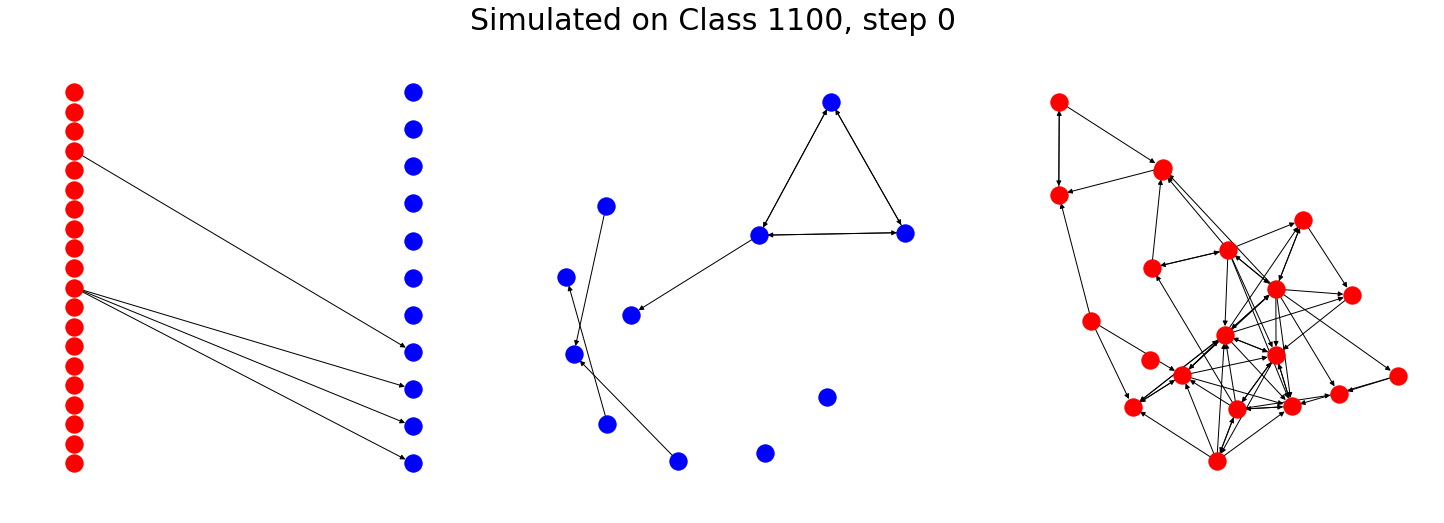

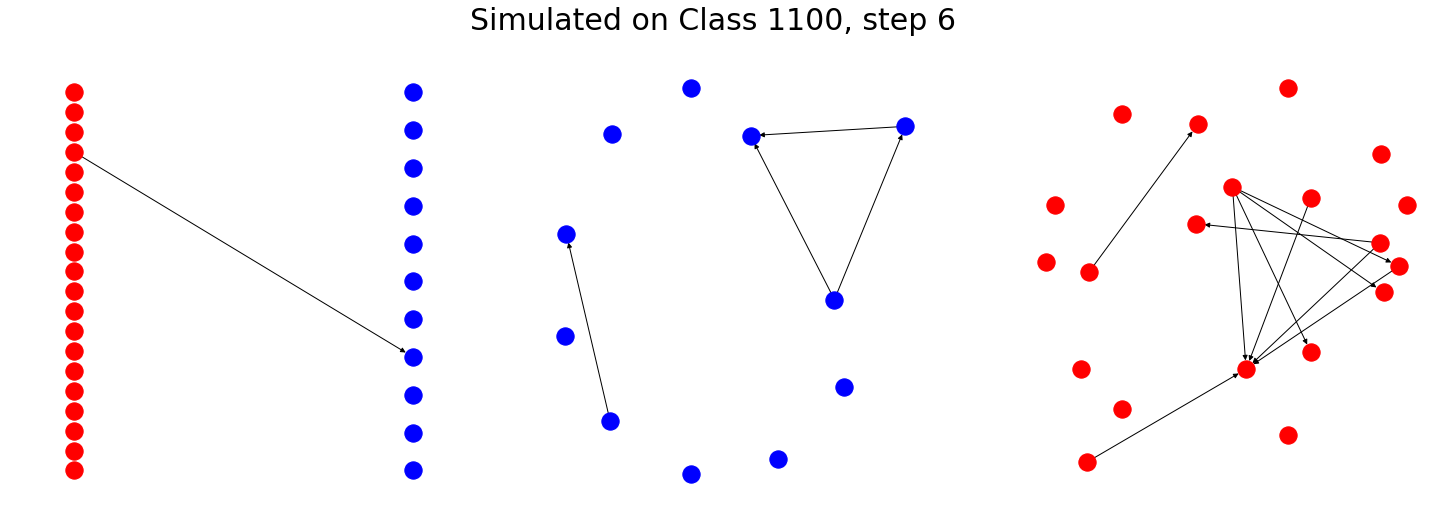

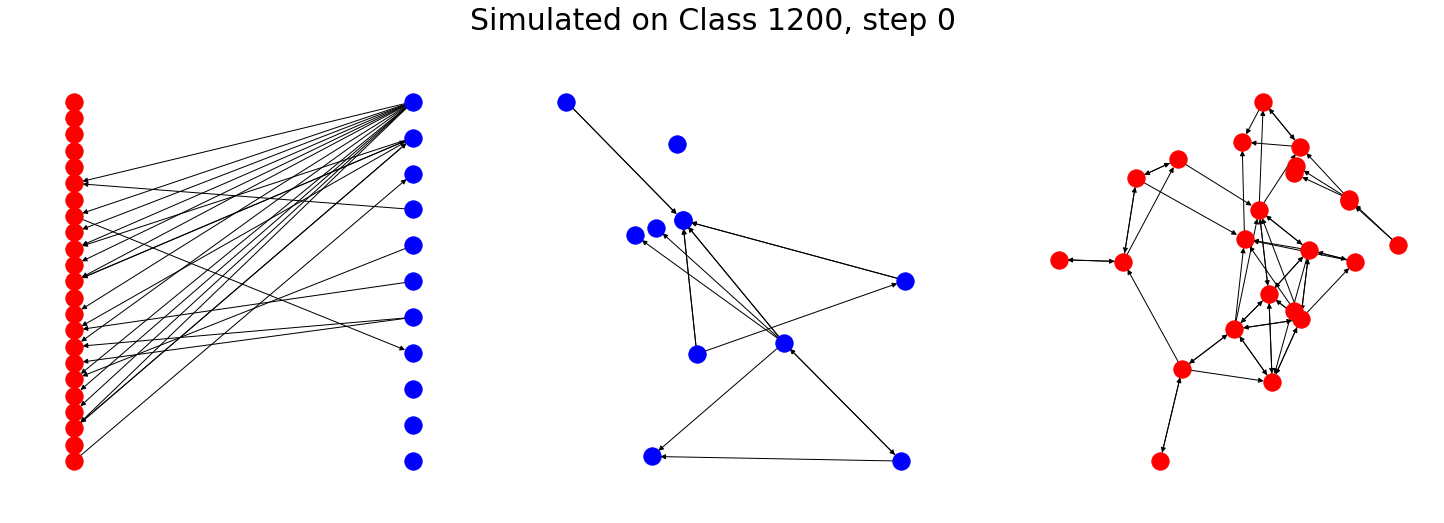

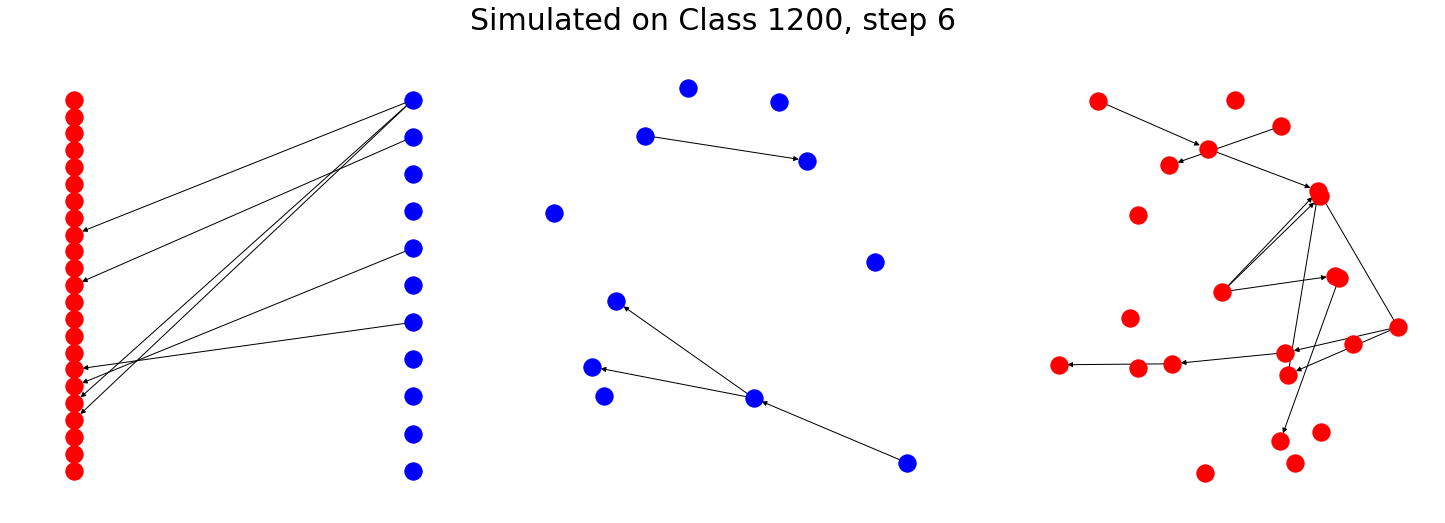

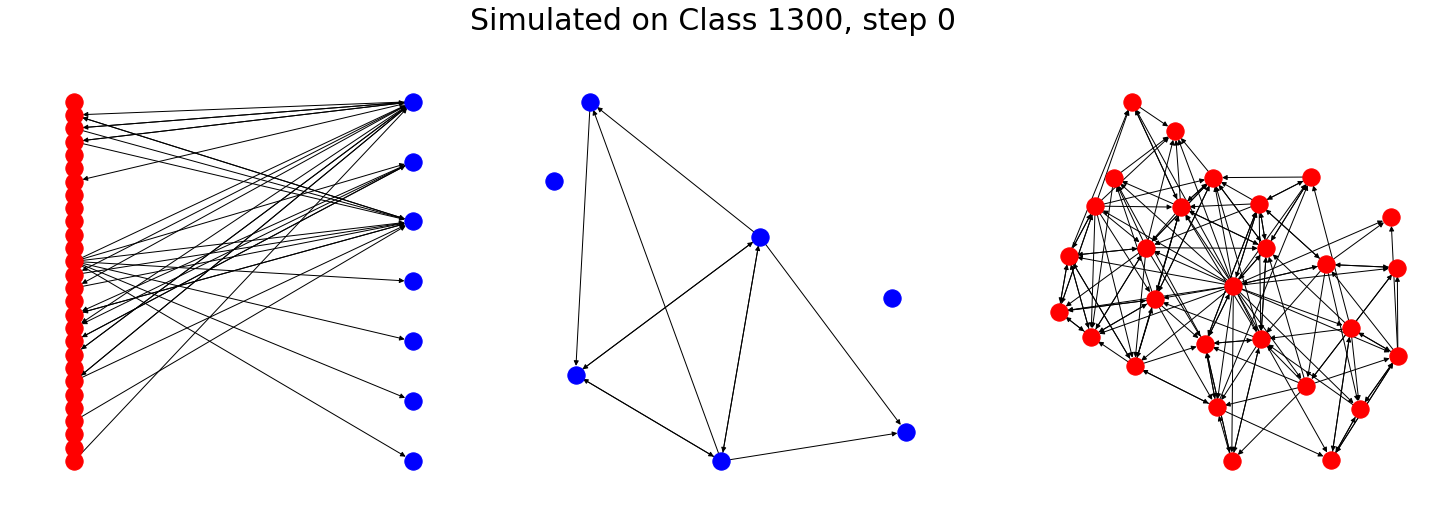

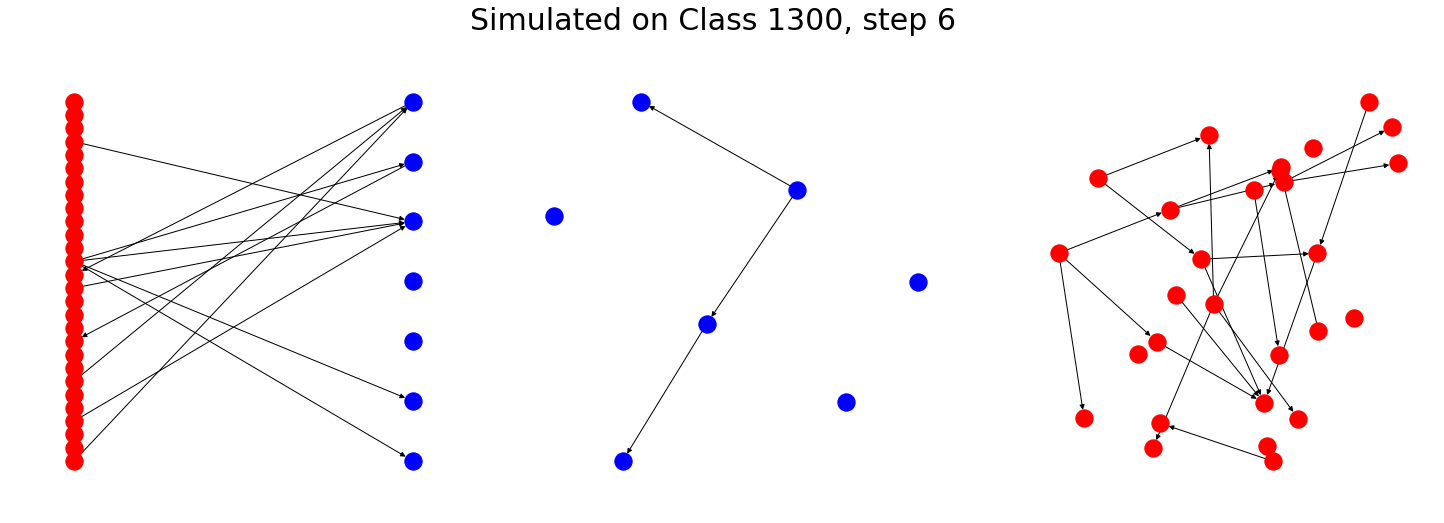

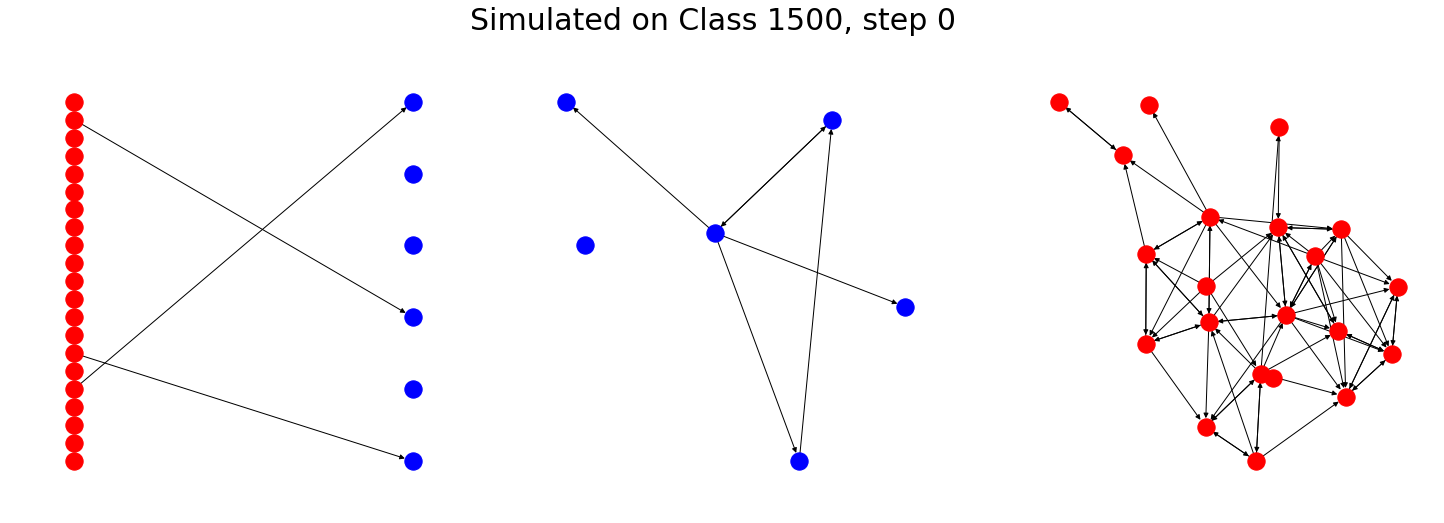

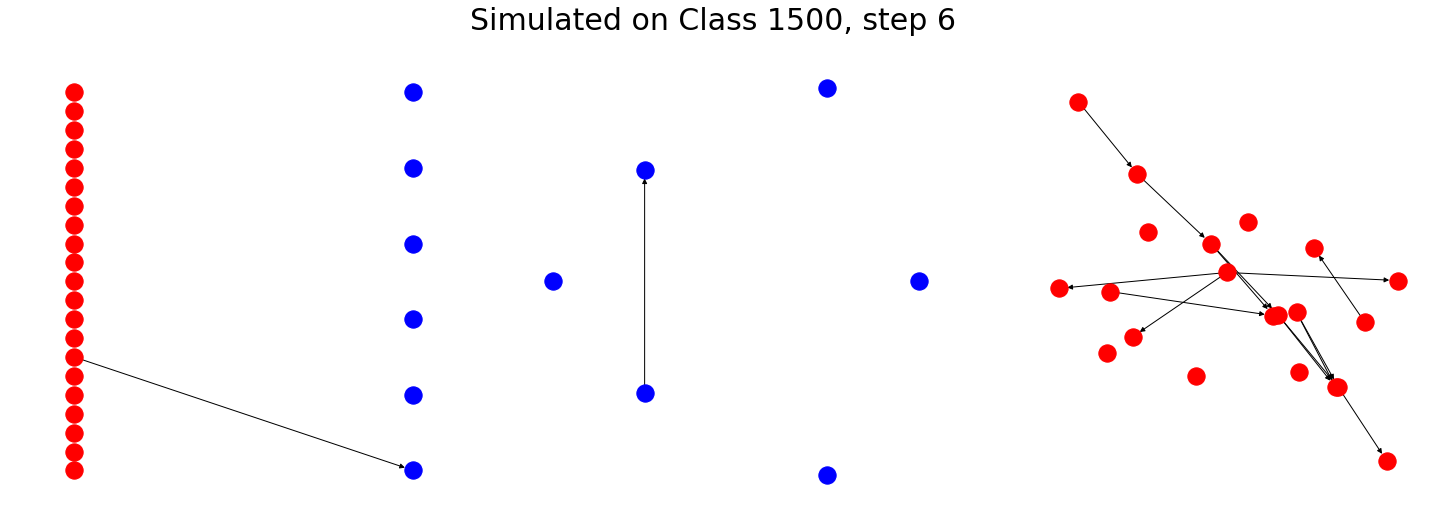

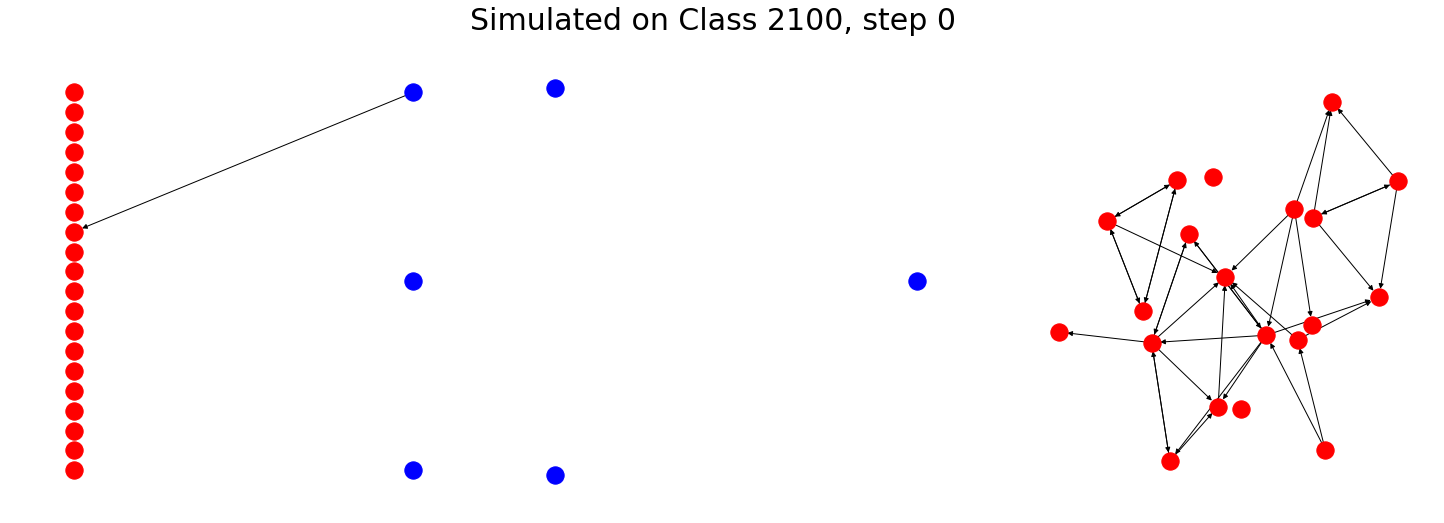

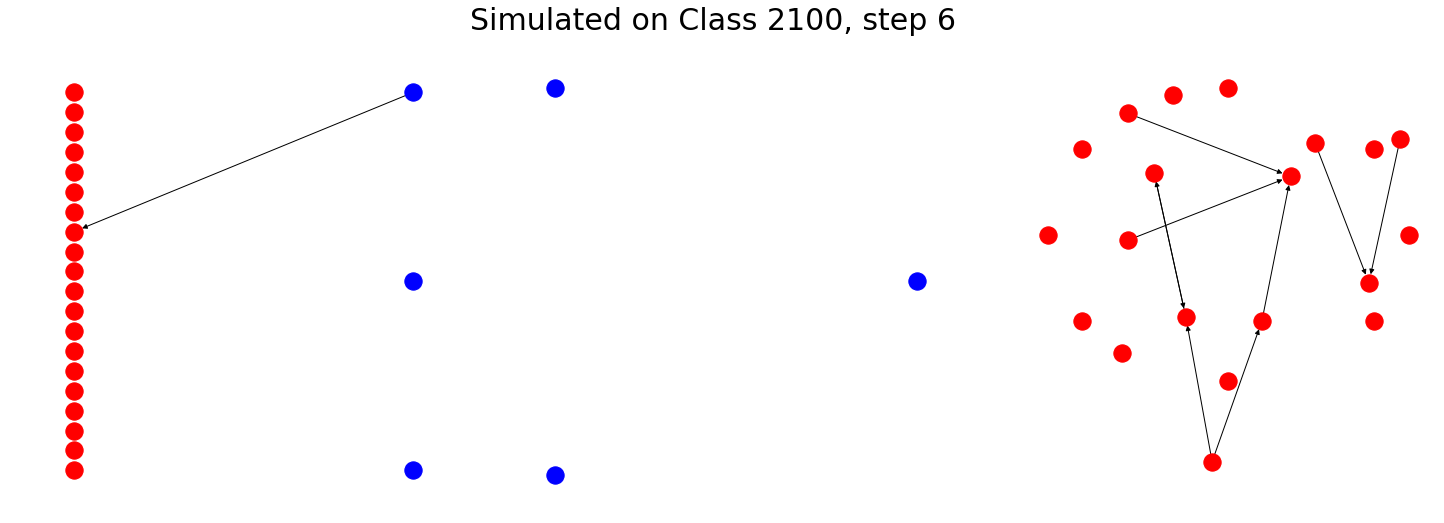

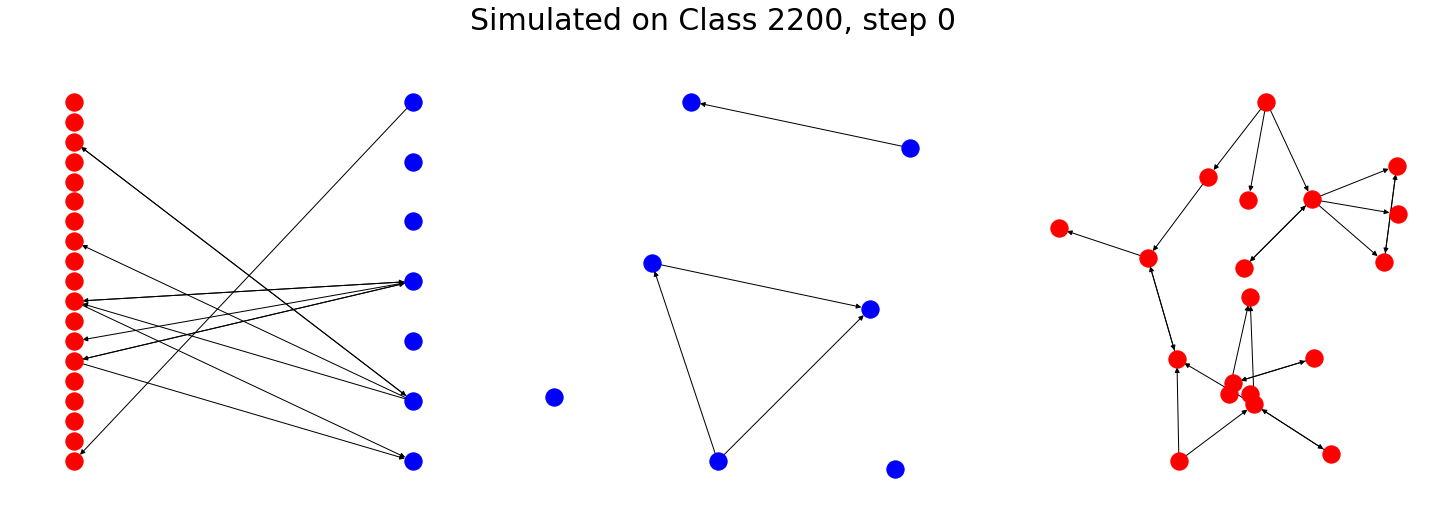

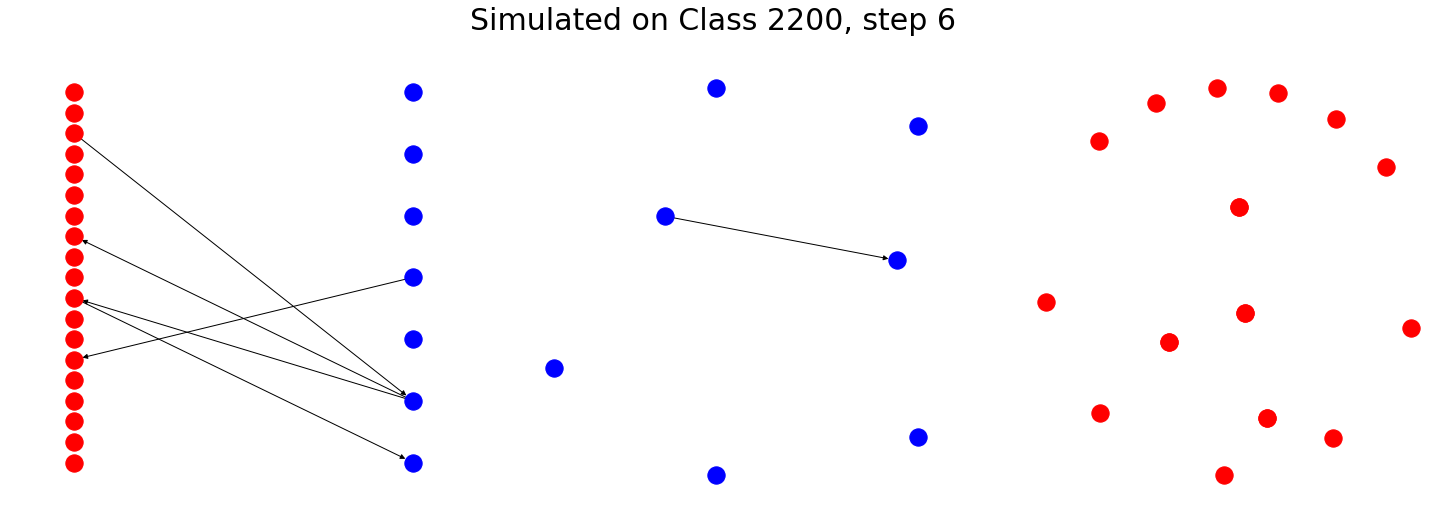

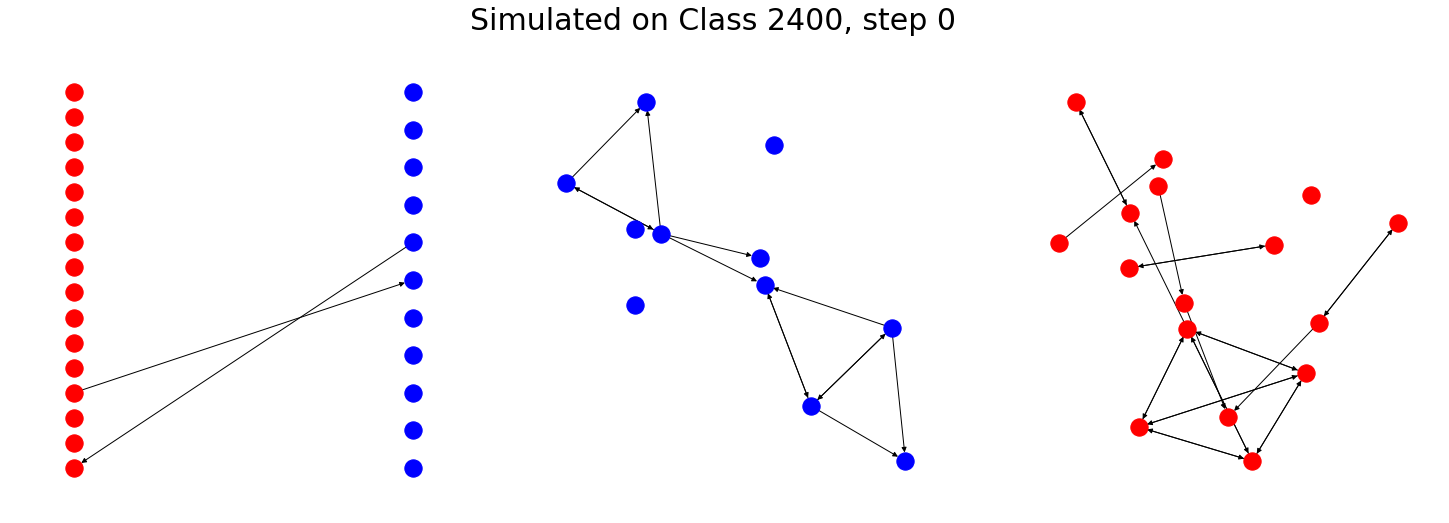

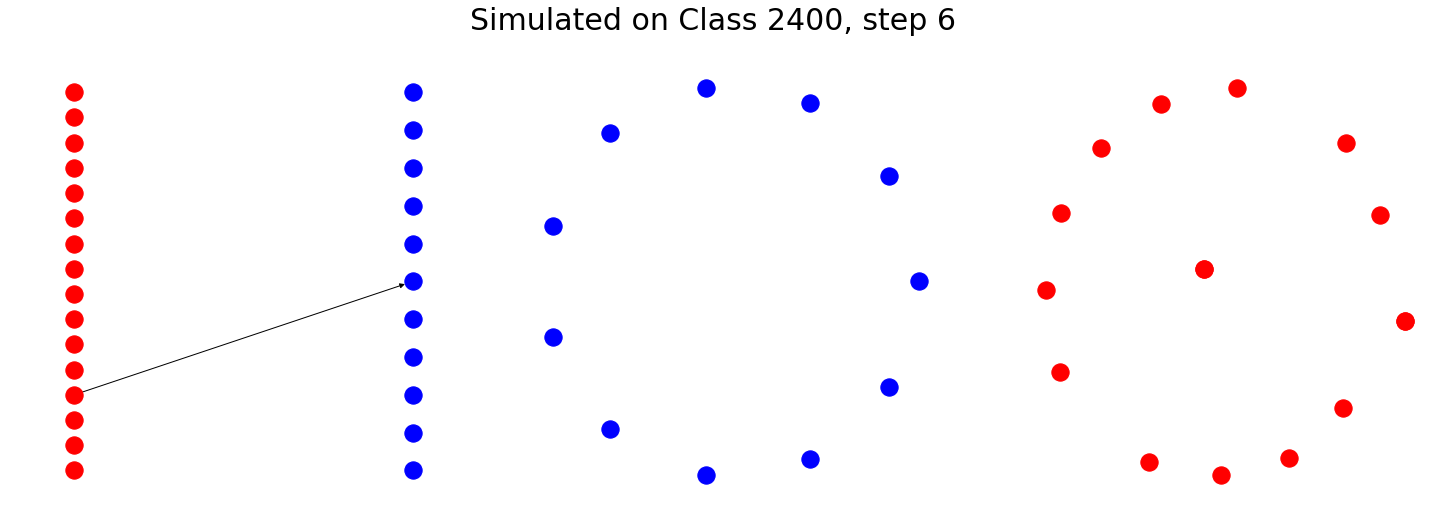

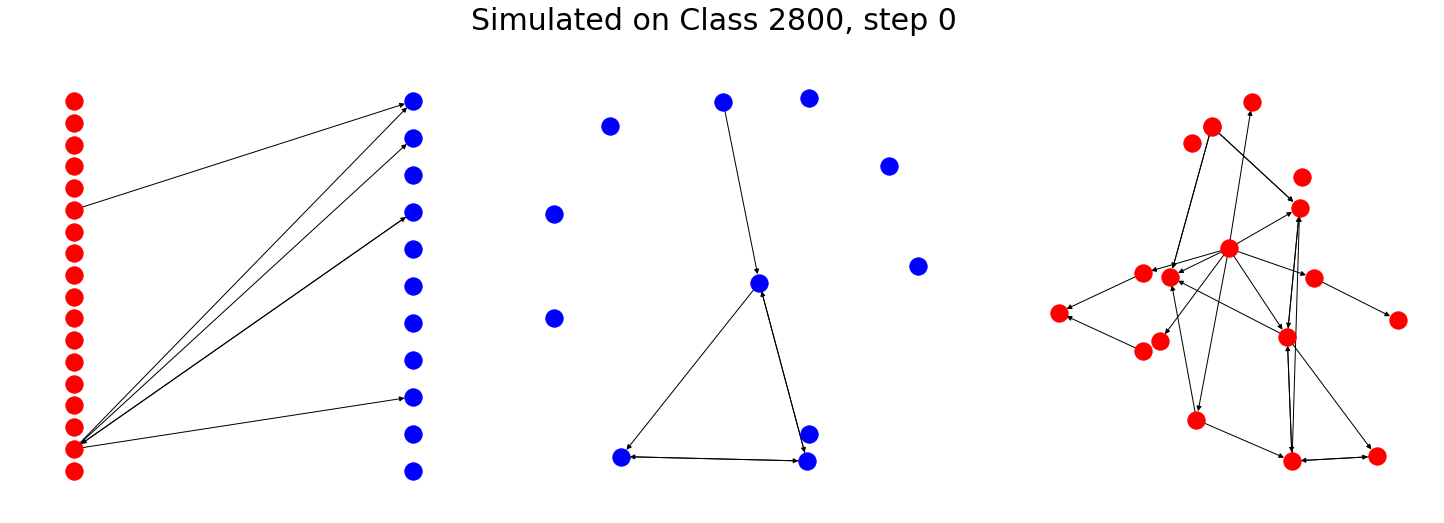

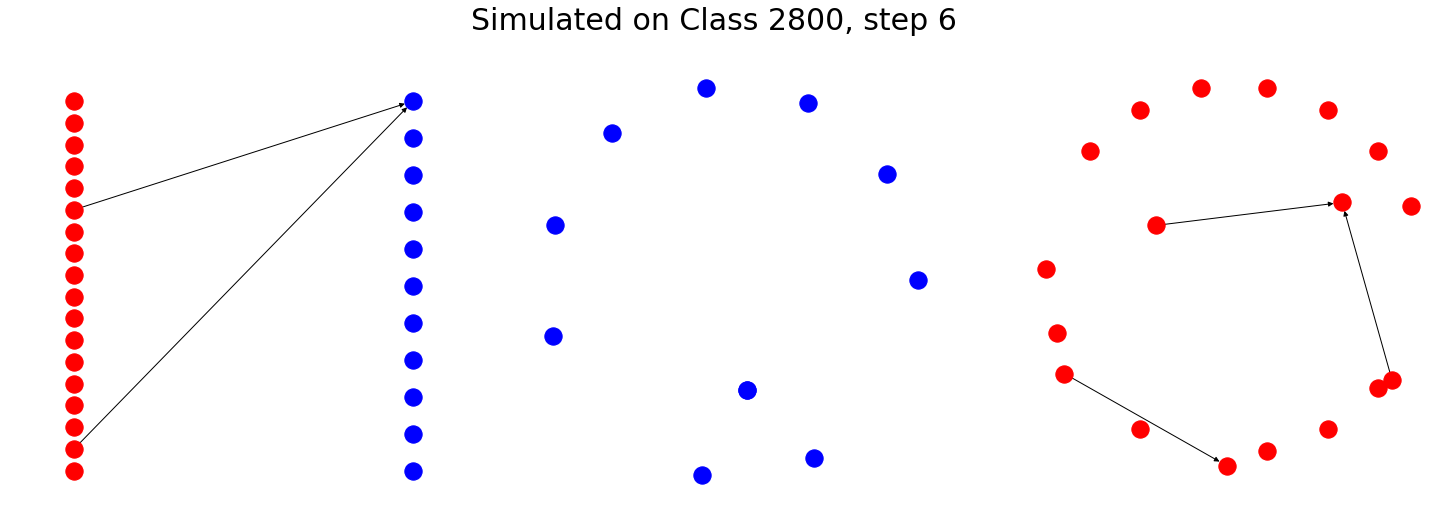

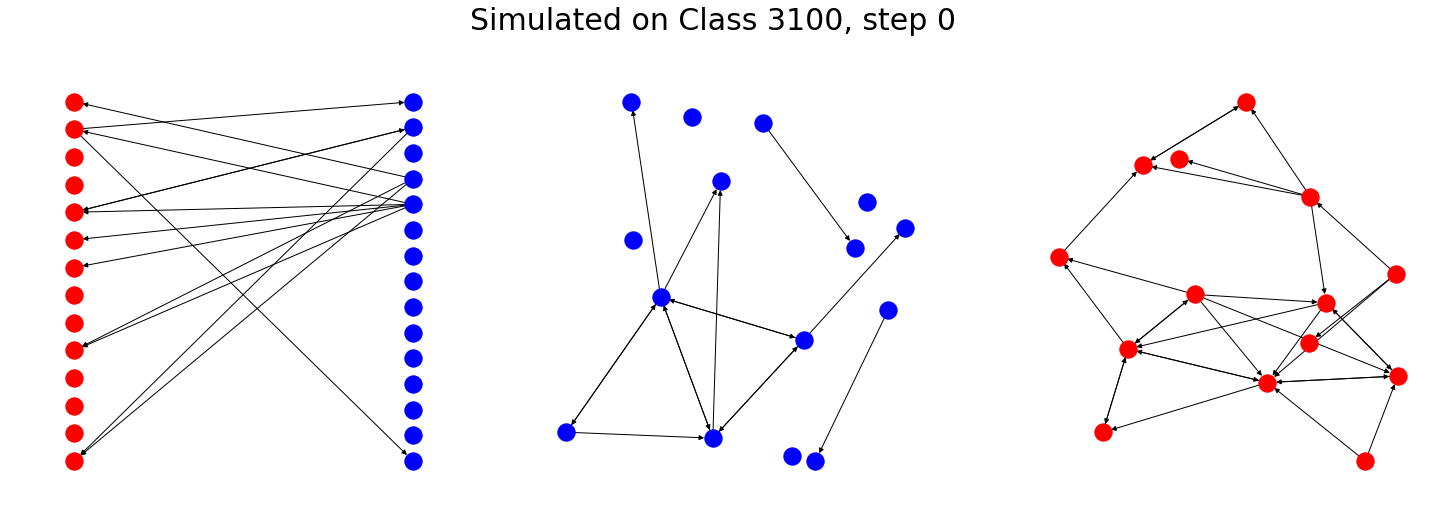

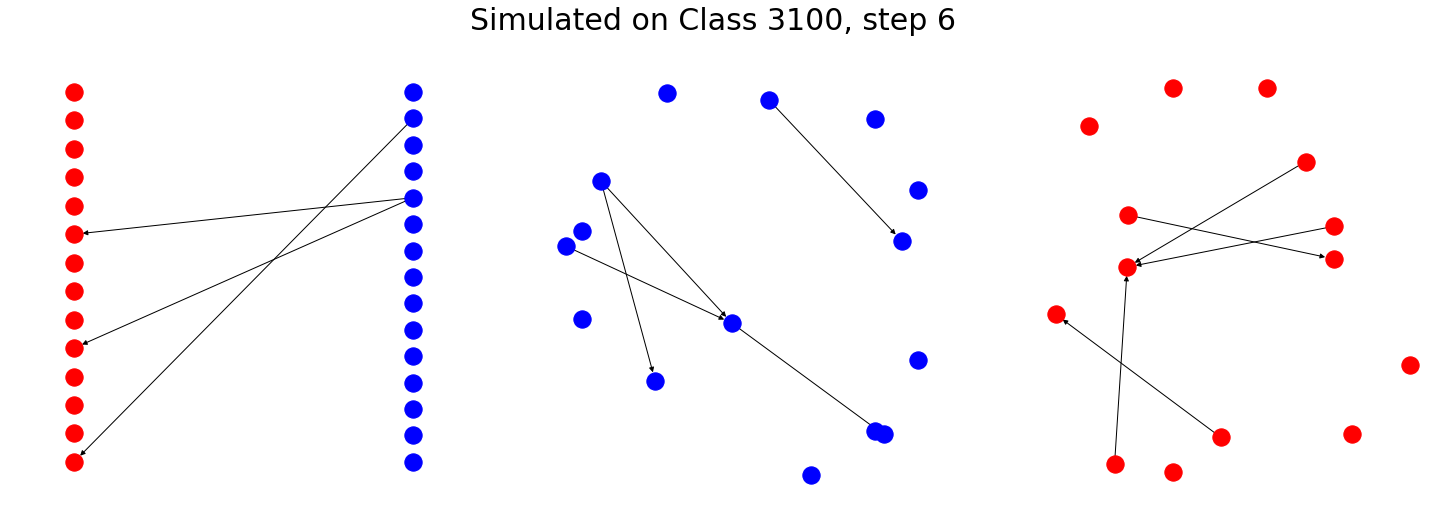

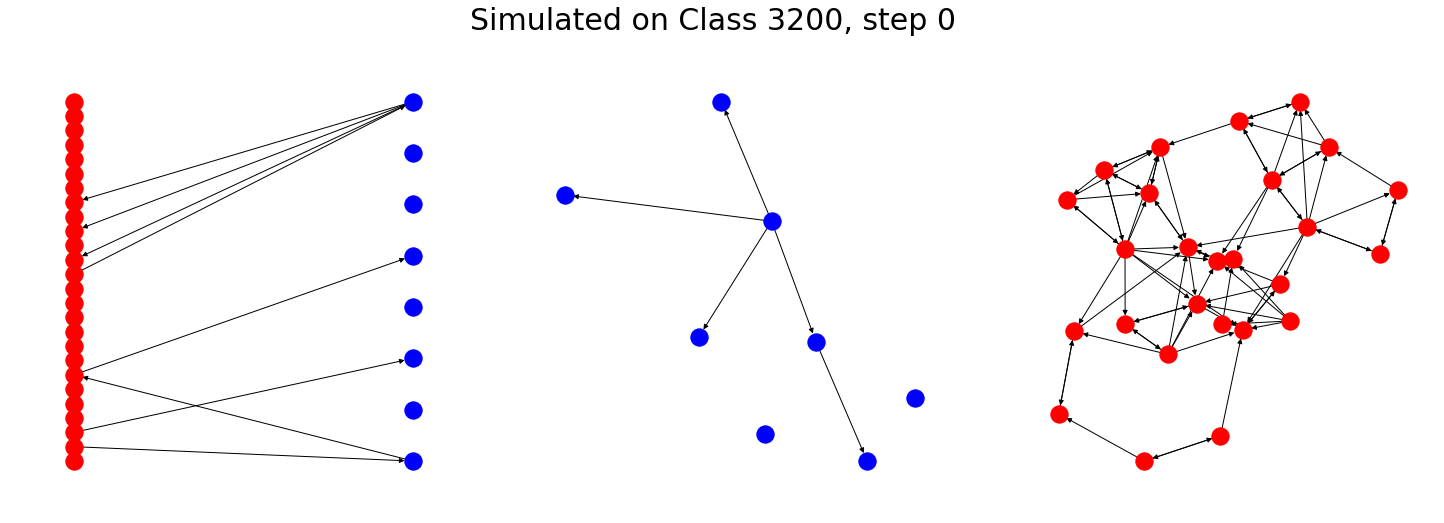

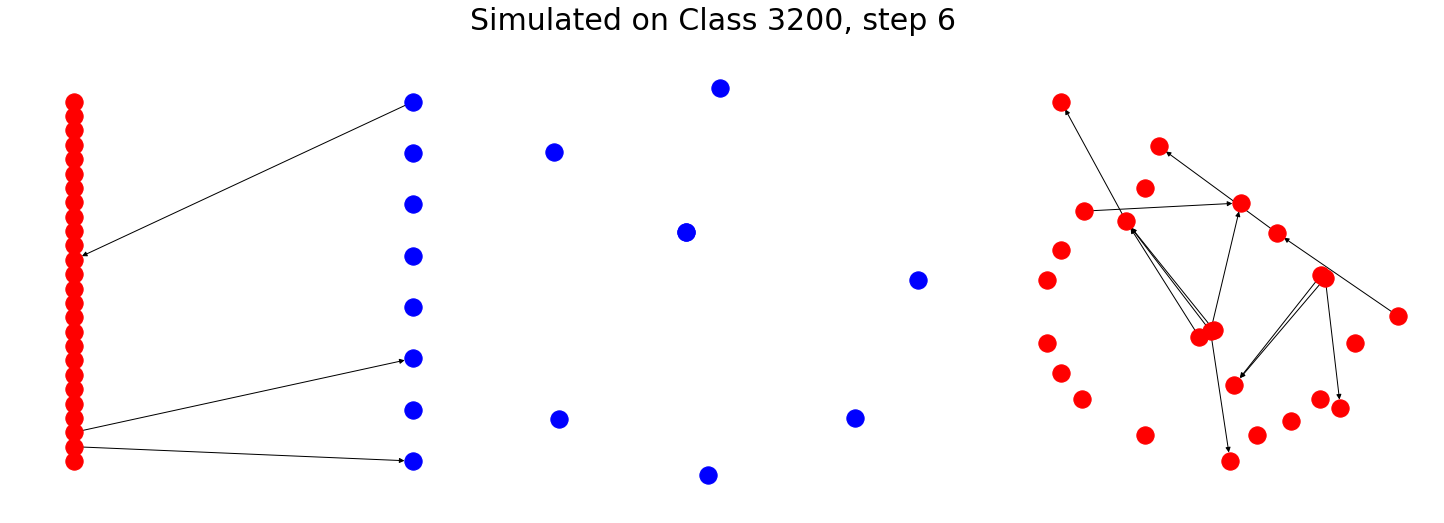

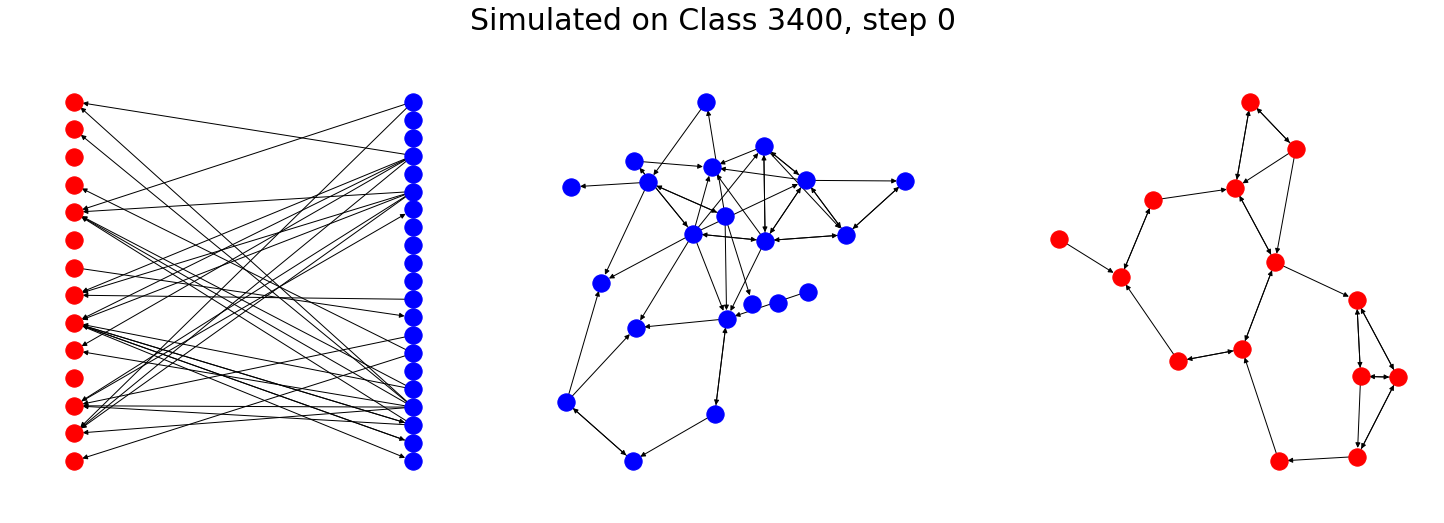

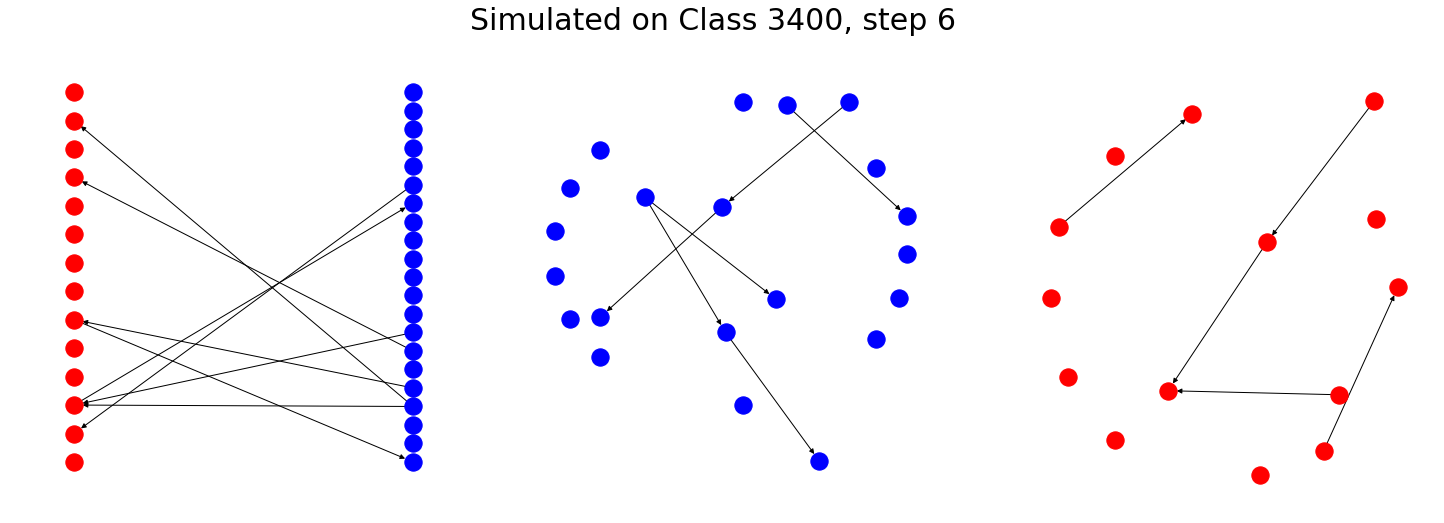

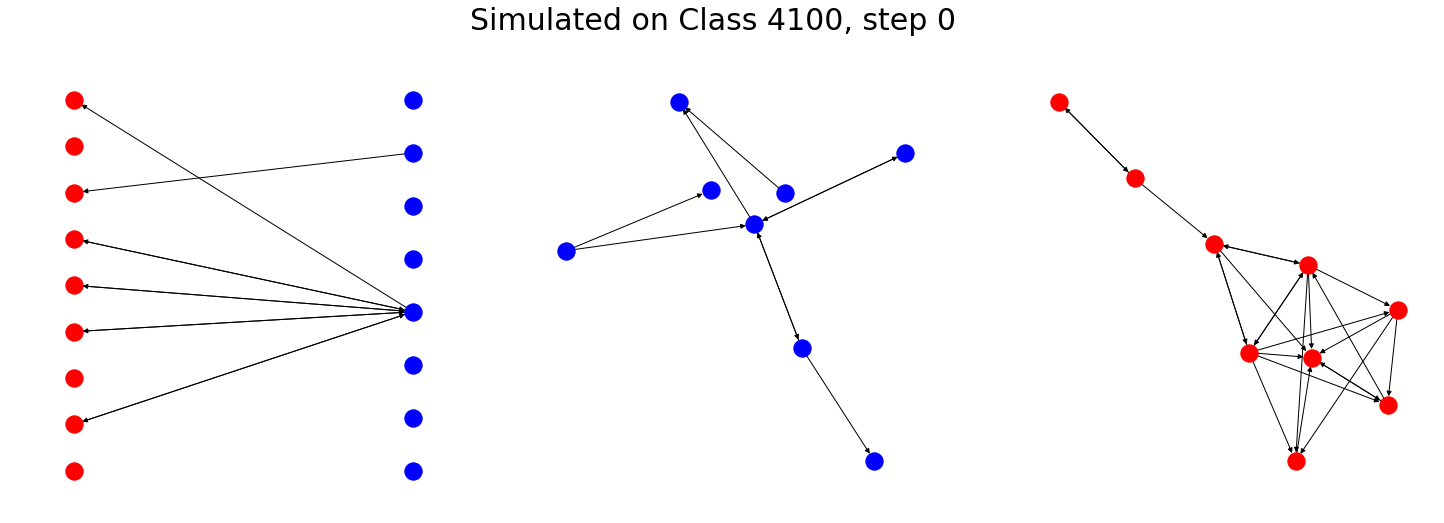

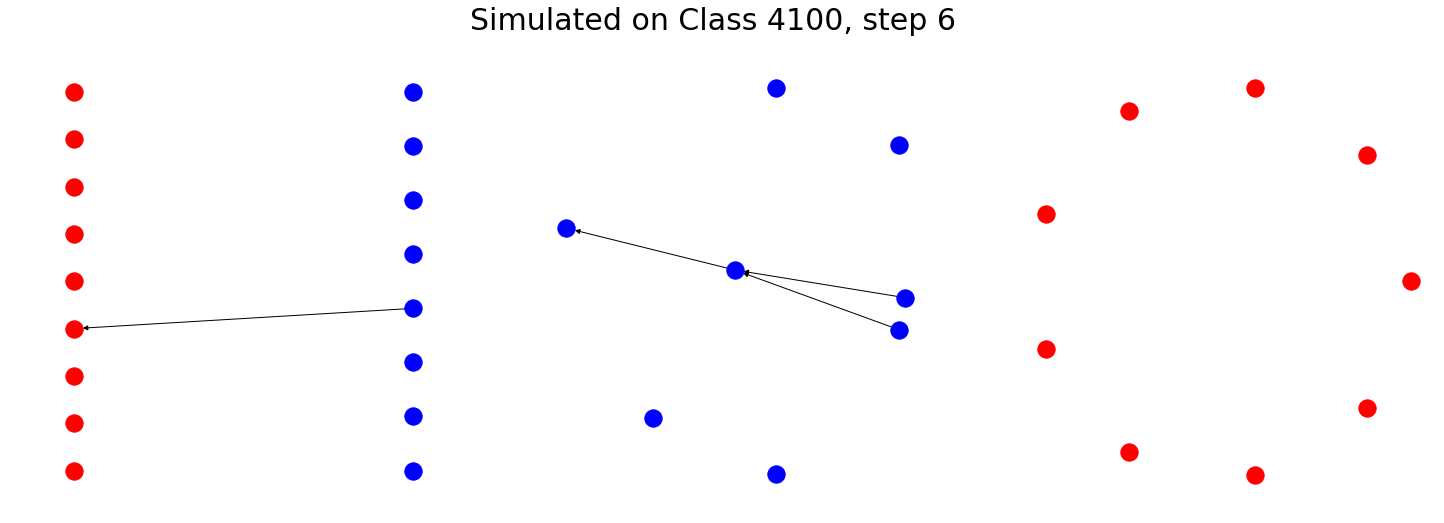

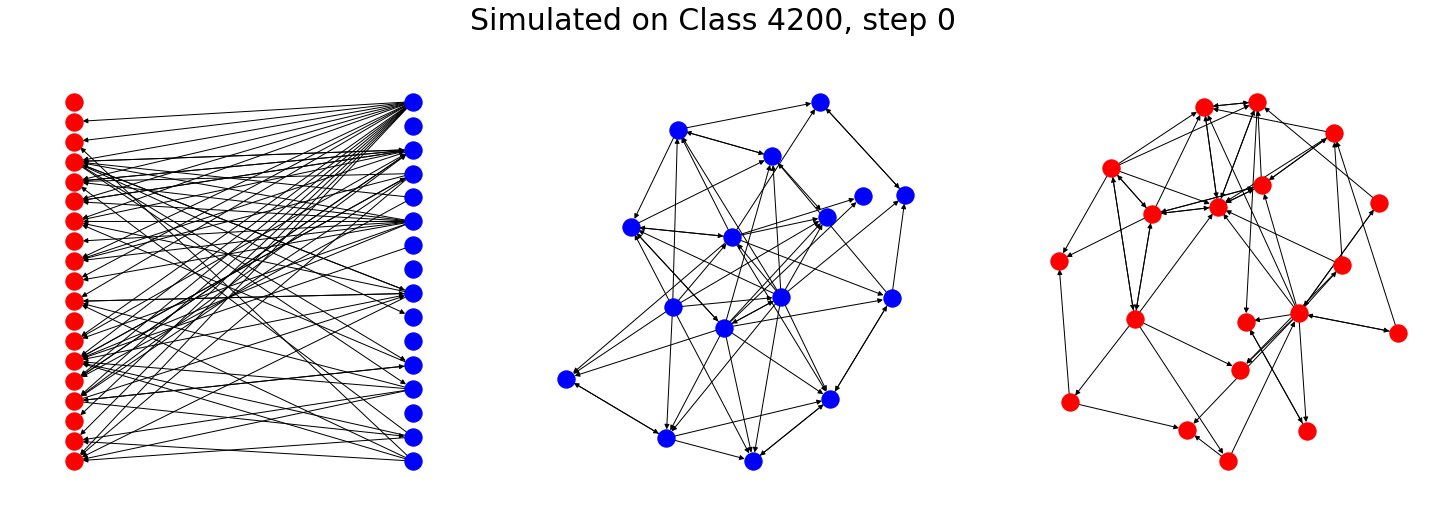

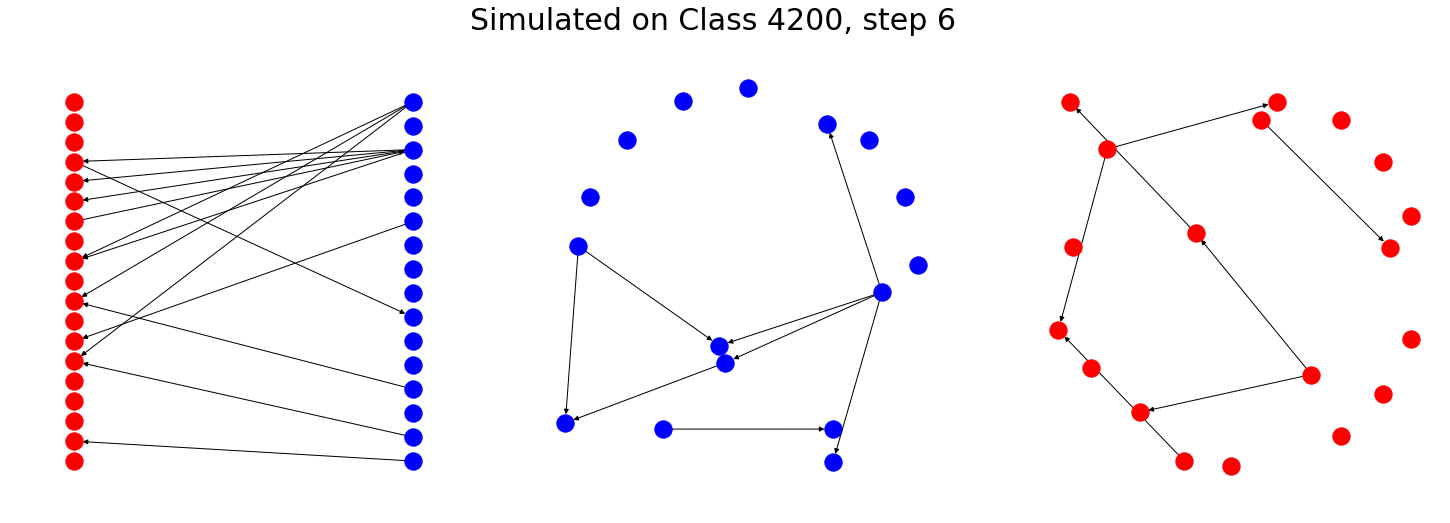

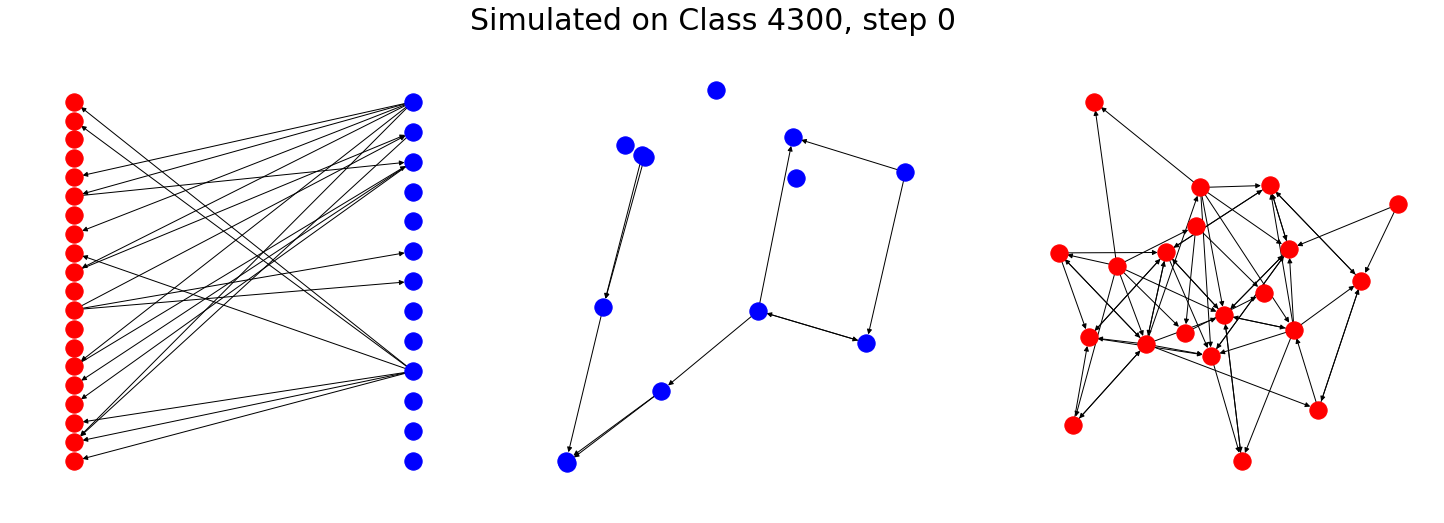

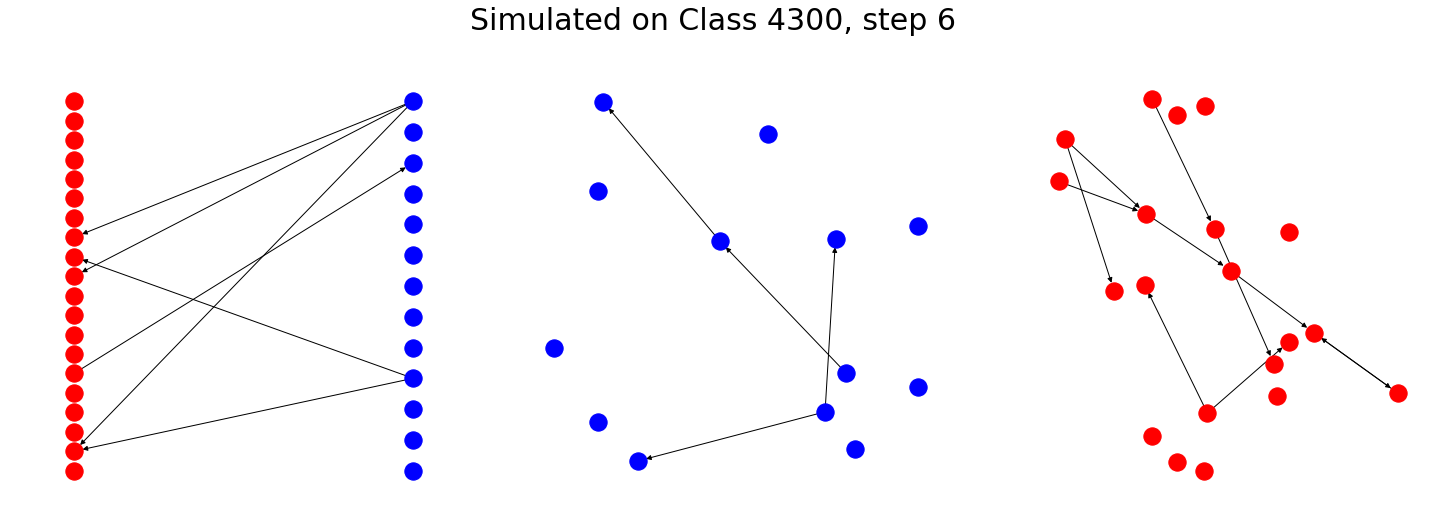

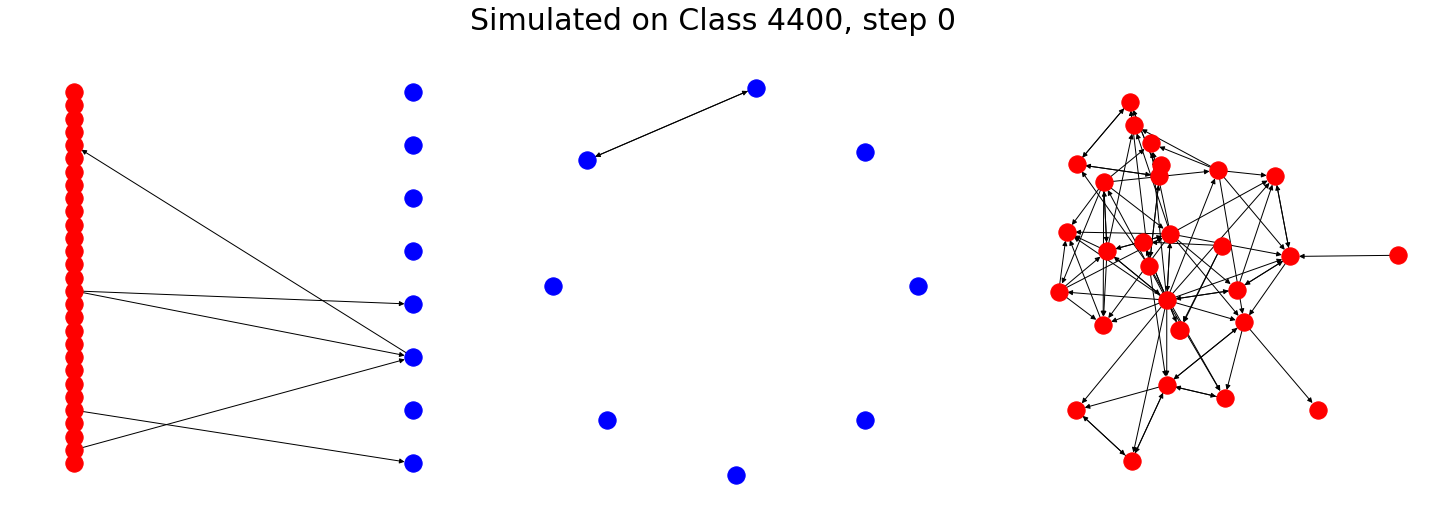

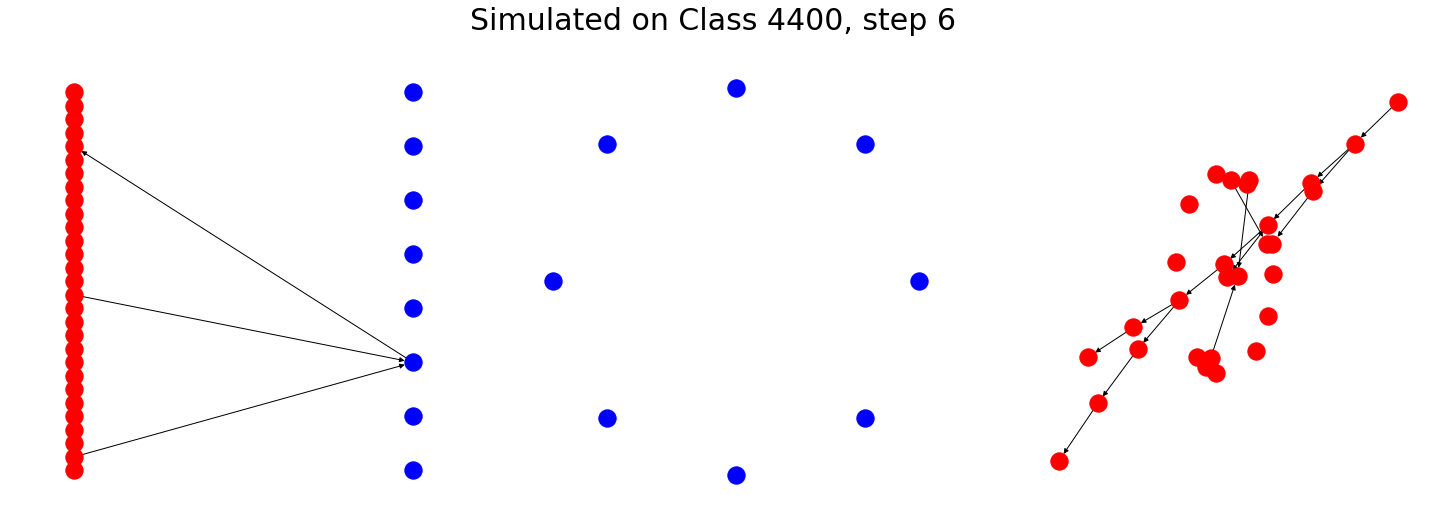

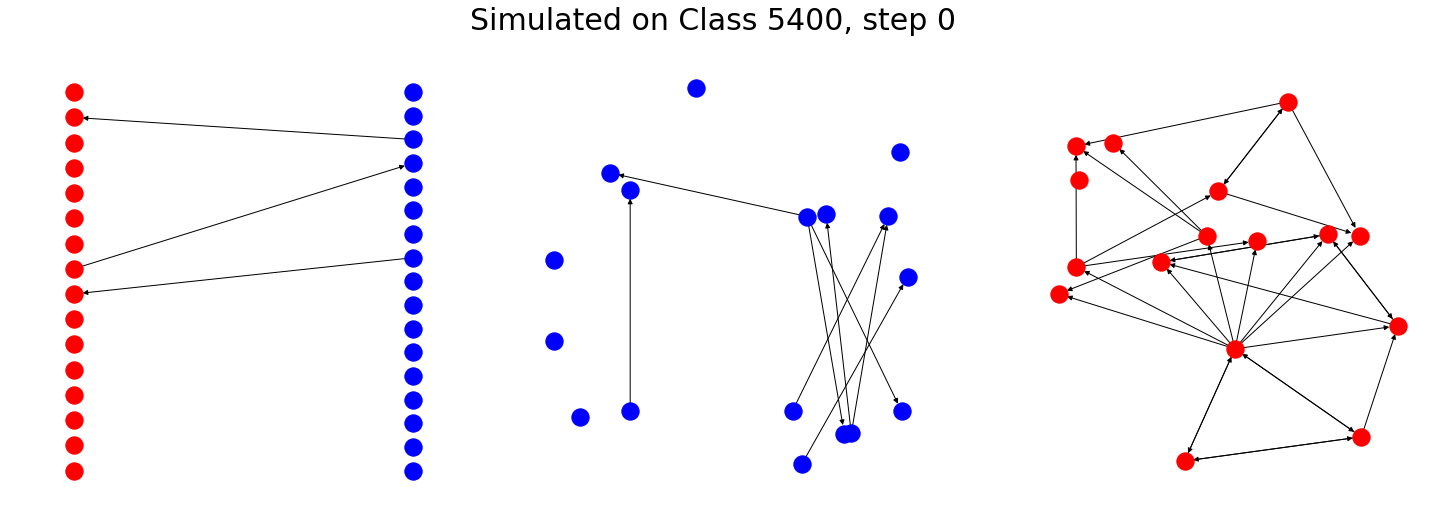

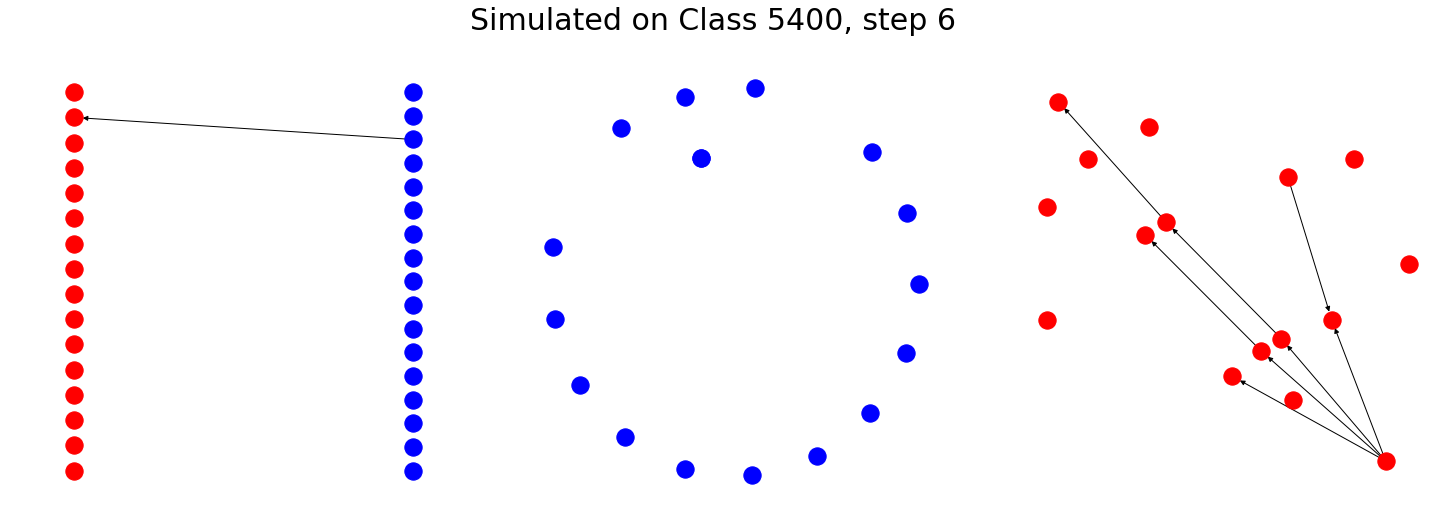

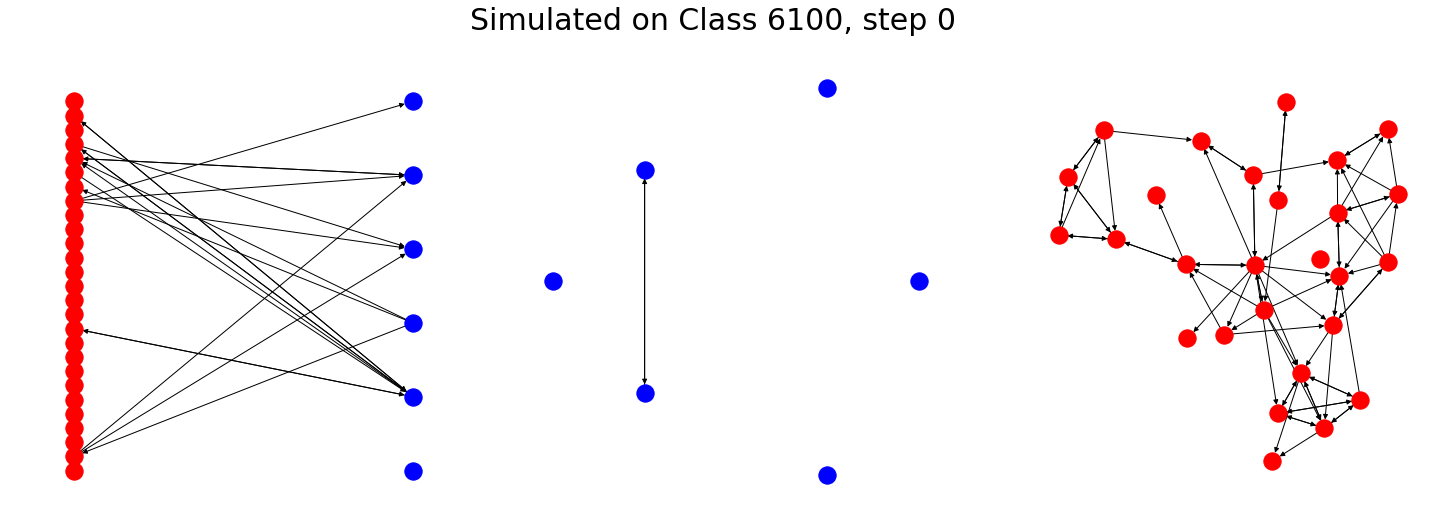

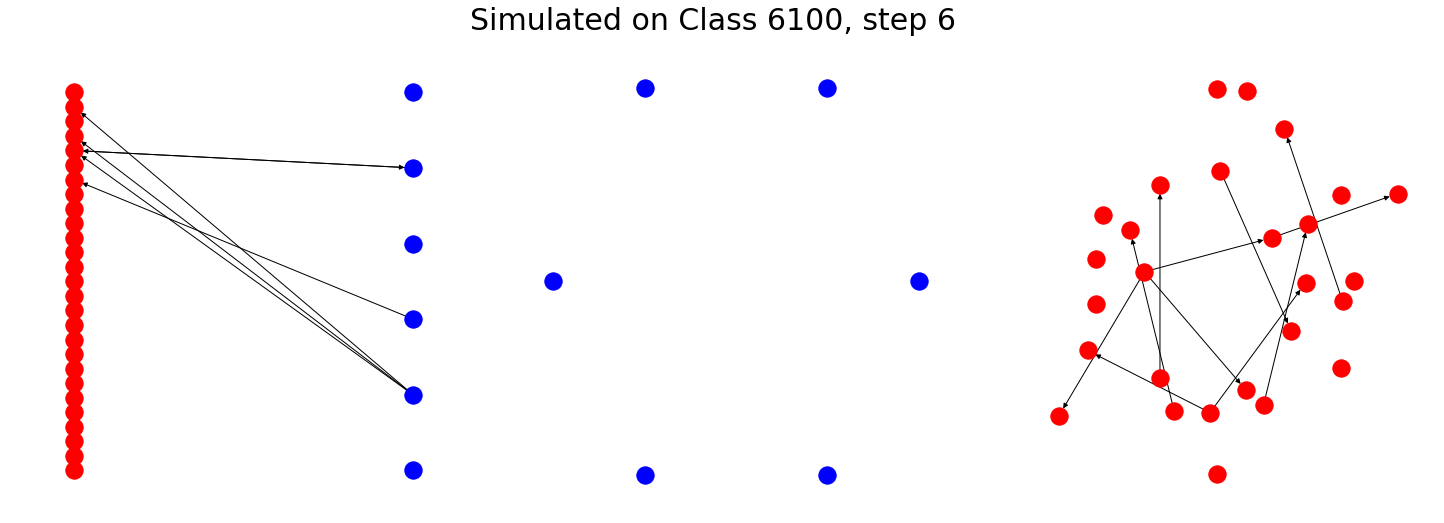

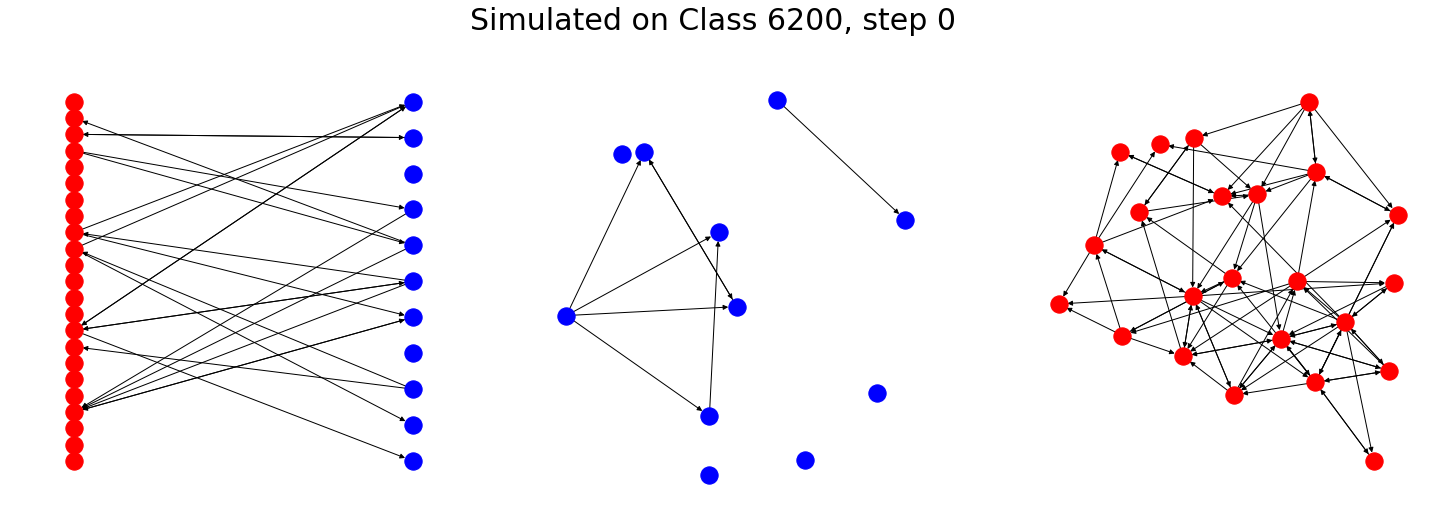

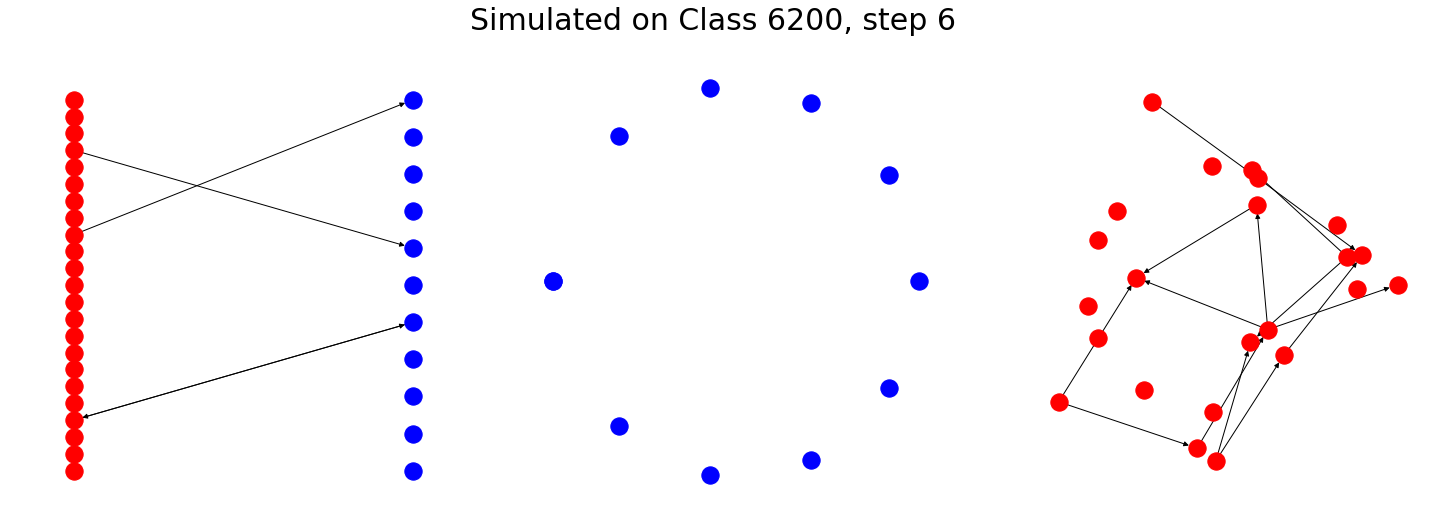

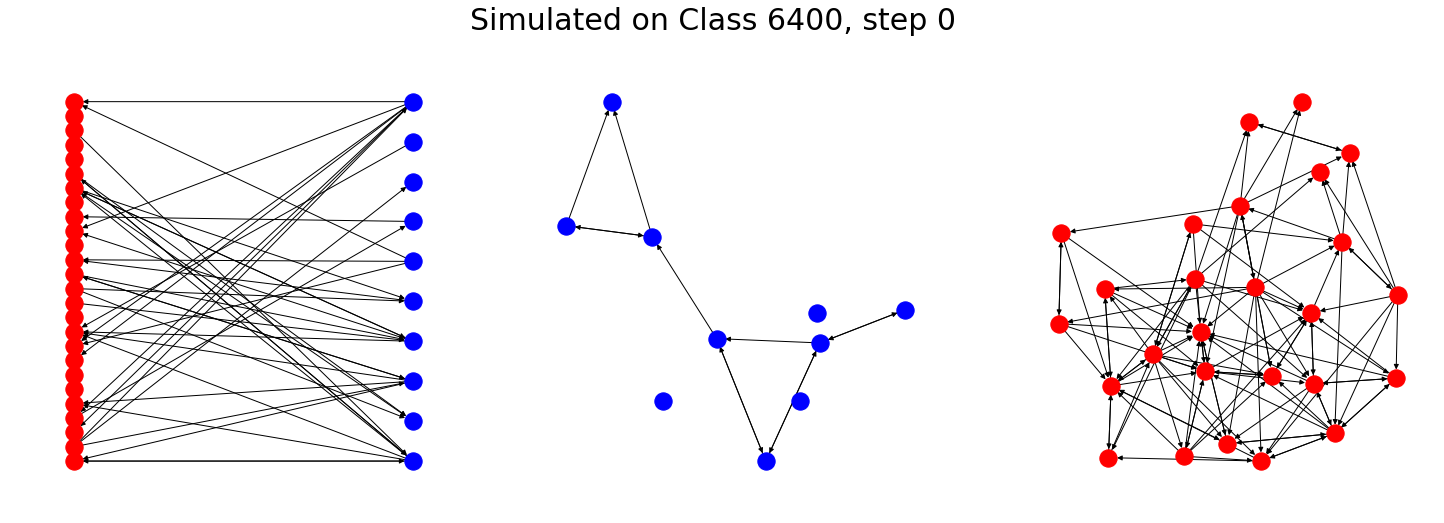

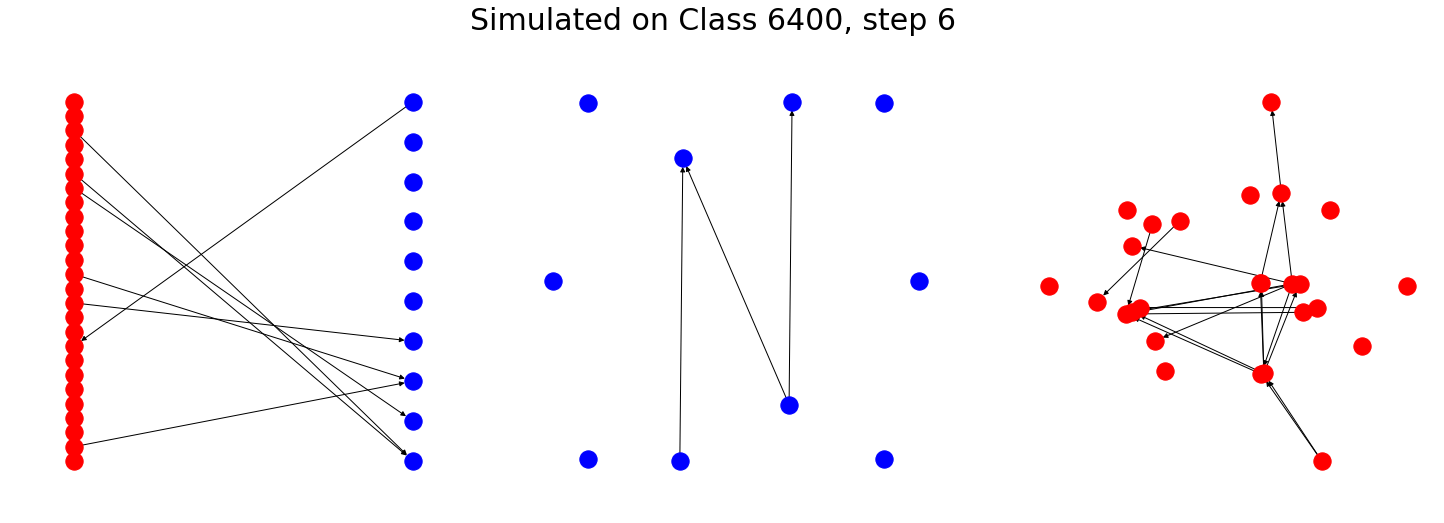

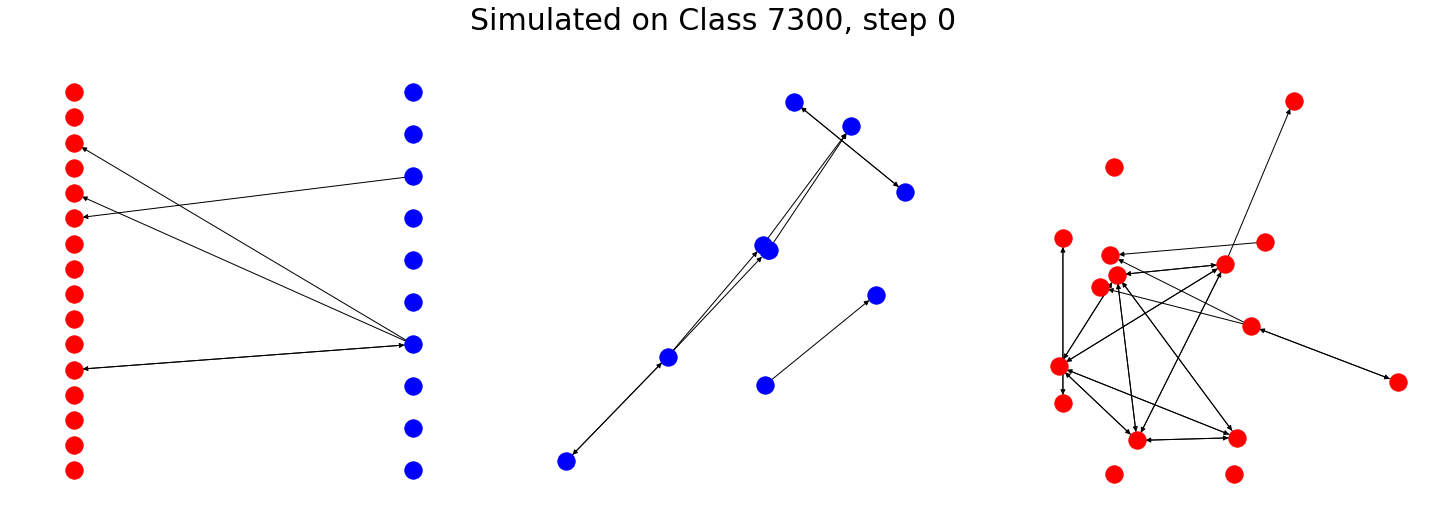

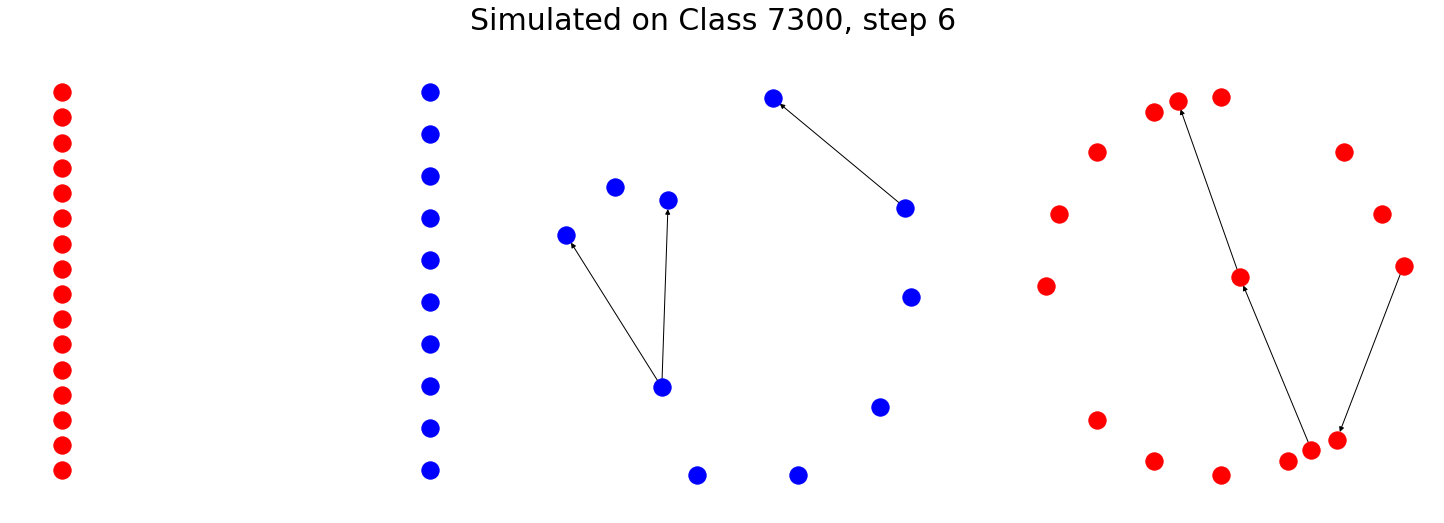

In [8]:
# Visualize all classes in step 0 and step #NUM_STEP
for class_id in class_ids:
    visualize(simulated_networks[class_id][0], class_id, 0)
    visualize(simulated_networks[class_id][NUM_STEP], class_id, NUM_STEP)

In [9]:
def plot_assortativity(networks):
    """
    Draw scatter plots of assortativity of step 0 and step 6
    """
    
    params = ['f2f', 'm2m', 'f2m', 'm2f']
    
    for param in params:
        x = []
        y = []
        for class_id in class_ids:
            f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][0])
            x.append(eval(param))
            f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][-1])
            y.append(eval(param))
            
        xymax = max(max(x), max(y)) + 0.05
        plt.xlim((-0.05, xymax))
        plt.ylim((-0.05, xymax))
        plt.suptitle('assortativity {}'.format(param), fontsize = 20)
        plt.scatter(x, y)
        plt.xlabel('Step 0')
        plt.ylabel('Step 6')
        
        # Calculate Pearson Correlation Coefficient
        corr = np.corrcoef(np.vstack([np.array(x), np.array(y)]))
        corr = round(corr[0][1], 2)
        
        # Linear Regression
        coef, error, _, _, _ = np.polyfit(x, y, 1, full = True)
        error = round(error[0], 2)
        plt.plot([-0.05, xymax], np.array([-0.05, xymax]) * coef[0] + coef[1], color='r')
        
        # Hard coding here, sad
        if param == 'f2f':
            plt.text(0.4, 0.4 * coef[0] + coef[1] - 0.2, \
            'slope = {} \n error = {} \n corr = {}'.format(round(coef[0], 2), error, corr))
        else:
            plt.text(xymax/2 + 0.02, xymax/2 * coef[0] + coef[1] - 0.12, \
            'slope = {} \n error = {} \n corr = {}'.format(round(coef[0], 2), error, corr))
        
        plt.savefig('assortativity {}.png'.format(param), dpi = 300)
        plt.show()

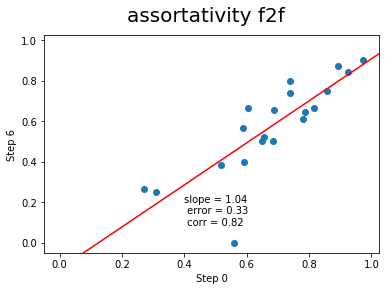

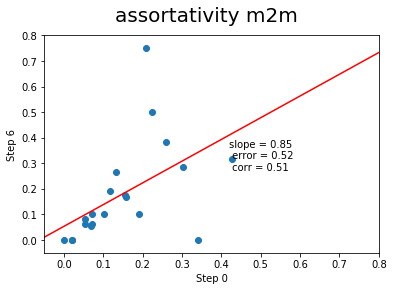

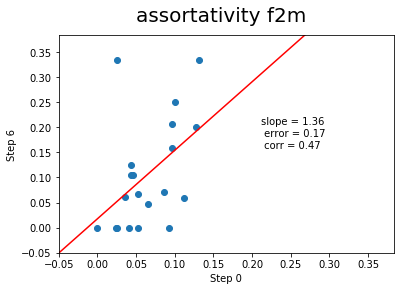

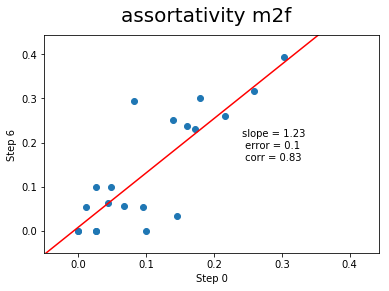

In [10]:
plot_assortativity(simulated_networks)

In [13]:
def get_parameters(networks):
    """
    Generate the csv file that records parameters of the simulated networks in step 6 for each class
    """
    
    df = pd.DataFrame(np.nan, index=class_ids, columns=['attribute', 'f2f', 'm2m', 'f2m', 'm2f', 'density'])

    for class_id in class_ids:
        f2f, m2m, f2m, m2f = get_assortativity(networks[class_id][-1])
        df.at[class_id, 'f2f'] = f2f
        df.at[class_id, 'm2m'] = m2m
        df.at[class_id, 'f2m'] = f2m
        df.at[class_id, 'm2f'] = m2f
        
        attribute_assortativity = nx.attribute_assortativity_coefficient(networks[class_id][-1], 'sex')
        attribute_assortativity = round(attribute_assortativity, 3)
        df.at[class_id, 'attribute'] =  attribute_assortativity
        
        density = nx.density(networks[class_id][-1])
        density = round(density, 3)
        df.at[class_id, 'density'] =  density
        
    print(df)
    df.to_csv('params for step 6.csv', sep='\t')
    

In [14]:
get_parameters(simulated_networks)

      attribute    f2f    m2m    f2m    m2f  density
1100      0.842  0.667  0.267  0.067  0.000    0.016
1200      0.430  0.565  0.174  0.000  0.261    0.020
1300      0.195  0.611  0.083  0.250  0.056    0.030
1500      0.636  0.875  0.062  0.062  0.000    0.023
2100      0.000  0.900  0.000  0.000  0.100    0.020
2200     -0.087  0.400  0.100  0.200  0.300    0.015
2400      0.000  0.667  0.000  0.333  0.000    0.004
2800      0.333  0.500  0.167  0.333  0.000    0.007
3100      0.562  0.385  0.385  0.000  0.231    0.016
3200      0.294  0.750  0.062  0.125  0.062    0.014
3400      0.191  0.263  0.316  0.105  0.316    0.016
4100      0.000  0.000  0.750  0.000  0.250    0.015
4200      0.157  0.250  0.286  0.071  0.393    0.024
4300      0.382  0.524  0.190  0.048  0.238    0.020
4400     -0.075  0.842  0.000  0.105  0.053    0.014
5400      0.615  0.800  0.100  0.000  0.100    0.009
6100     -0.109  0.647  0.000  0.059  0.294    0.016
6200      0.224  0.737  0.053  0.158  0.053   